# Data Driven Gait Analysis

## Classification of Cross-Country Skiing Techniques Using Supervised Learning
### TRA105 Digitalization in Sports | Chalmers University of Technology
#### Group Members:
 - David Larsson [larsdav@student.chalmers.se]
 - Savya Sachi Gupta [savya@student.chalmers.se]
 
 ---
 ---
 
 In this notebook, we will be looking build a Random Forest Classifier model to identify Gait in skiers. Further details regarding the setup of these experiments has been provided in their respective sections. Please note that this notebook focuses on only the implementation of classification models and their performance on data. Any information regarding the raw data, pre-processing of raw data, cleaning, preparation etc can be found within the files present in the `analysis_setup_functions` and `dataframe_functions` files of this package.
 
 ## Instructions:
  - Please ensure that all packages/libraries/dependencies are installed on your system
  - Two user defined libraries are present in the this package which are accessed by the first two lines of the <a id="lines"></a>[importing libraries](#lib) module. If you are unable to access them via the folder, you may copy and paste both the files in the same directory as this notebook and edit the import command accordingly to simply reflect the filenames
  - Under the <a id="lines_2"></a>'[Loading the Dataset](#data)' code block, you will see `path_first` and `path_second` that point to the raw skier data that we want to load. Please ensure that these paths exist on your system and their relative filepath as specified in the variables are functioning for you.
  - **Note**: The following are the user defined functions that have been used in this notebook:
      - from `dataframe_functions`:
         - `get_dataframe` : function to load all skier data into this notebook. It also shifts the data by 12 seconds to align the data more accurately
      - from `analysis_setup_functions`:
         - `split_train_test_data` : function to split skier data into train and validation datasets. Randomly selects `validation_skiers = 3` to randomly select 3 skiers from the entire list to consider as validation data and the remaining as training data.
         - `tune_random_forest` : Function to perform hyperparameter tuning for a random forest classifier model
         - `evaluate` : Function to predict labels for the validation data. Performs 5-fold cross-validation and returns confusion matrix, classifier performance metrics. It is a generic function and is used for both random forest and logistic regression. 
         - `plot_predicted_gear_comparison` : plots the true labels of the validation data as a line plot and superimposes a scatterplot with the predicted labels to visually show the accuracy of the model in classifying the gears. We have the Gear Numbers on the y-axis and No. of observations on the x-axis.
         - `refine_predicted_labels` : Function that applies a Majority Filter on the predicted labels of width 15, which will look at the neighboring 15 values of a label and update it with the value of the most frequently occurring label in that window. This function is being used to evaluate if refining the predicted labels by removing skewness in between gears can improve the quality of our results.

**You can understand more about these functions by reading through their files where they have been defined and explained in detail**

<a id="home"></a>

## Contents
You may click on these links to navigate to different sections of the notebook directly. 

*(These links may not work when viewed on GitHub or Colab directly, you may download and open the file on jupyter or equivalient for this functionality. Alternatively for Colab, you can use the left panel to navigate the sections)*

1. [Setting up the Random Forest Classifier Method](#rfc)
2. [Cross Validation of Model](#rfc_cv)
3. [Summary of Cross Validation](#rfc_summary)
4. [Additional Experiments using Model](#rfc_extra)
5. [Observations of Random Forest Classifier](#rfc_obs)

We also perform a refininement of predicted labels using a majority filter technique and evaluate its results by repeating experiments similar to the ones listed above. These can be accessed byy the below links.

6. [Setting up the Refined Results using Majority Filter](#refined)
7. [Cross Validation and Refining Predicted Labels](#refined_cv)
8. [Summary of Cross Validation and Comparison of Refined Results](#refined_summary)
9. [Additional Experiments by Refining Predicted Labels](#refined_extra)
10. [Observations of Refined Predicted Lables](#refined_obs)

#### Skier Profile
Below are the Skier Profiles for the 10 Subjects this data was recorded from:

| Skier | Gender | Mass (kg) | Height (cm) | Pole Length (cm) | Body Mass Index (BMI) |
|-------|--------|-----------|-------------|------------------|-----------------------|
| 1     | Man    | 87.5      | 190         | 167.5            | 24.2                  |
| 2     | Man    | 78.5      | 190         | 167.5            | 21.7                  |
| 3     | Man    | 88.3      | 190         | 167.5            | 24.5                  |
| 4     | Kvinna | 63.9      | 161         | 147.5            | 24.7                  |
| 5     | Man    | 77.6      | 186         | 160              | 22.4                  |
| 6     | Man    | 69.8      | 178         | 160              | 22.0                  |
| 7     | Kvinna | 64        | 161         | 147.5            | 24.7                  |
| 8     | Man    | 66.6      | 176         | 157.5            | 21.5                  |
| 9     | Man    | 73.3      | 186         | 160              | 21.2                  |
| 10    | Kvinna | 60.5      | 185         | 160              | 17.7                  |

---
---
---

##### Importing Libraries
<a id="lib"></a>
[Back to Top](#lines)


In [1]:
from dataframe_functions import *
from analysis_setup_functions import *

from IPython.display import HTML
import pandas as pd
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn import metrics

<a id="data"></a>
##### Loading the Dataset
[Back to Top](#lines_2)


We load the entire dataset of all the skiers together, so that we can later split into trianing and test according to our convenience. If you want to change the number of skiers that should be chosen for validation, please change the `validation_skiers` variable to a number of your choice. We have set it to 3. `df_info` is the dataframe which contains all the information useful for running our model and that is the one used by us in this notebook.

In [2]:
path_first = './data/'
skier_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
path_second = '_csvData.csv'
filepath_list = [path_first + str(i) + path_second for i in skier_list]

main_df, df_peaks, df_info = get_dataframe(filepath_list, skier_list)

# No. of Skiers to use for testing
validation_skiers = 3

---
---
---
<a id="rfc"></a>
# RANDOM FOREST CLASSIFIER
[Back To Top](#home)

---

Now that we have our data loaded from the above code block, we will see how well a random forest classifier method performs in identifying the gears. The execution of our experiment using random forest classifier will be carried out in the following steps:
 - Load training and validation data based on randomly selected skiers data
 - Perform hyperparameter tuning for a random forest classifier model on this dataset
 - Perform cross validation by randomly selecting skiers for training and validation and evaluate the validation data using the tuned model and return performance metrics for this model
 - Plot the predicted and True gears of validation data to visualize quality of predictions made
 - Store all results
 - **Repeat all the above steps again for a new set of training and validation skiers**
 
 
The experiment is performed within the `for` loop which is used to repeat the experiments for 10 runs (in our case). We will then view the results across all the runs and see if the performance of this method is consistent, and share our observations.

## Hyperparameter Tuning

In [3]:
display(HTML(f'<p><strong><span style="font-size: 24px; color: rgb(0, 168, 133);">Hyperparameter Tuning</span></strong></p>'))

#Load training and validation data based on randomly selected skiers
X_train, X_valid, y_train, y_valid, y_plot_data, train_skiers_list, val_skiers_list = split_train_test_data(df_info, skier_list, validation_skiers, to_train=True)

# Perform hyperparameter tuning for a random forest classifier model on this dataset
rfc, rfc_best_params = tune_random_forest(X_train, y_train)

**********************************************************************************************
Randomly Splitting Data into Training and Validation Sets...
(11204, 7) (4803, 7) (11204,) (4803,)
Performing Hyperparameter Tuning...

Best Parameters after Randomized Search CV : 
{'n_estimators': 97, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 200, 'class_weight': 'balanced_subsample', 'bootstrap': False}




## Feature Importance Score Plot

After tuning the random forest classifier, we also would like to see the feature importance scores assigned to the features of our dataset. However, we will not be performing any feature selection by removing any feature as there are very few features in comparison the the number of samples of data. 

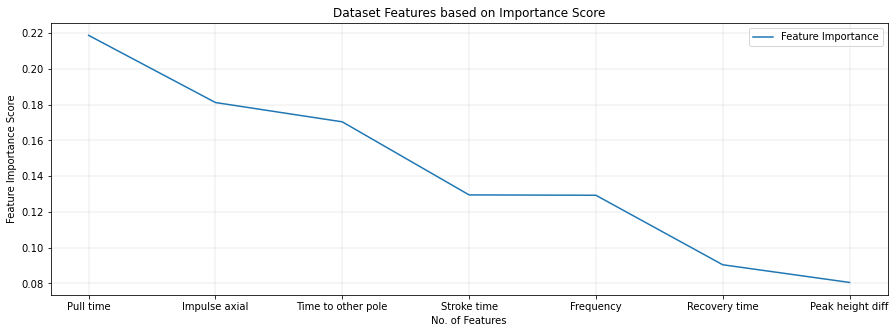


Feature Importance Scores:

[['0.2188' 'Pull time']
 ['0.1812' 'Impulse axial']
 ['0.1704' 'Time to other pole']
 ['0.1295' 'Stroke time']
 ['0.1293' 'Frequency']
 ['0.0904' 'Recovery time']
 ['0.0805' 'Peak height diff']]


In [4]:
plot_feature_importance(rfc, X_train, y_train)

<a id="rfc_cv"></a>
## Cross Validation on Tuned Model
[Back To Top](#home)


**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [1, 2, 3, 4, 5, 7, 10]
Validation Skiers : [6, 9, 8]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.791,0.75,0.698,0.75,0.712,0.688,0.777



Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      1809
           2       0.83      0.89      0.86       540
           3       0.84      0.69      0.76      2161
           4       0.26      0.49      0.34       251

    accuracy                           0.79      4761
   macro avg       0.70      0.75      0.71      4761
weighted avg       0.82      0.79      0.80      4761



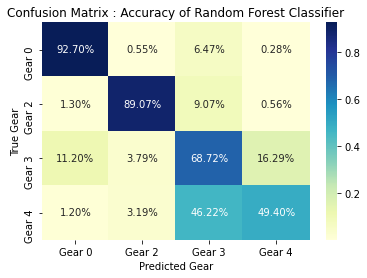

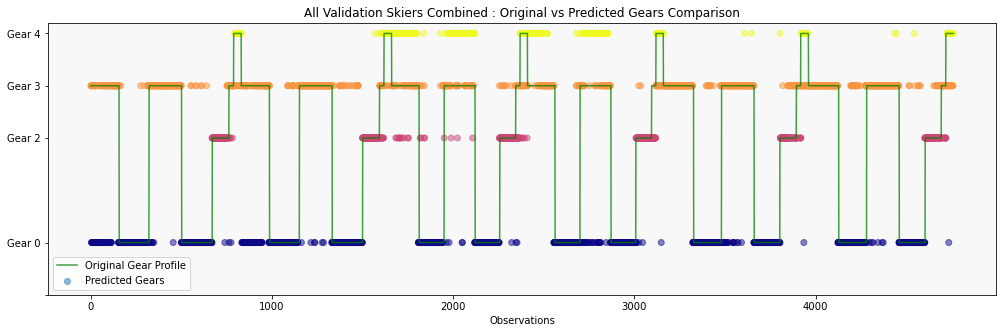

**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [1, 2, 3, 5, 6, 8, 10]
Validation Skiers : [7, 4, 9]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.765,0.76,0.711,0.76,0.728,0.666,0.645



Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.70      0.77      1818
           2       0.72      0.91      0.81       686
           3       0.83      0.81      0.82      2017
           4       0.45      0.62      0.52       487

    accuracy                           0.77      5008
   macro avg       0.71      0.76      0.73      5008
weighted avg       0.78      0.77      0.77      5008



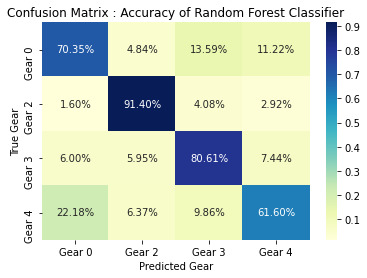

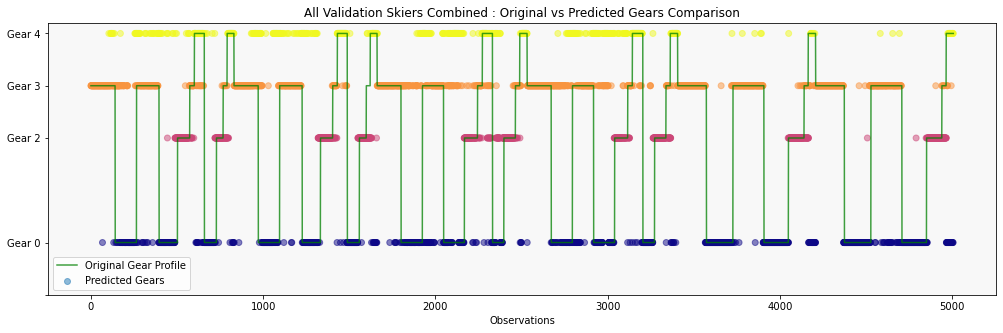




**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [1, 2, 3, 5, 8, 9, 10]
Validation Skiers : [4, 6, 7]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.786,0.803,0.747,0.803,0.767,0.695,0.554



Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.76      0.80      1892
           2       0.77      0.89      0.83       691
           3       0.84      0.77      0.80      1998
           4       0.54      0.78      0.64       486

    accuracy                           0.79      5067
   macro avg       0.75      0.80      0.77      5067
weighted avg       0.80      0.79      0.79      5067



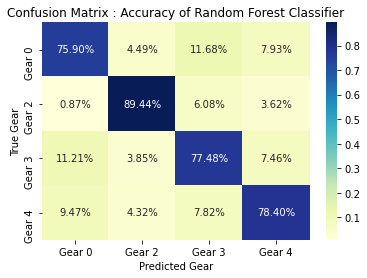

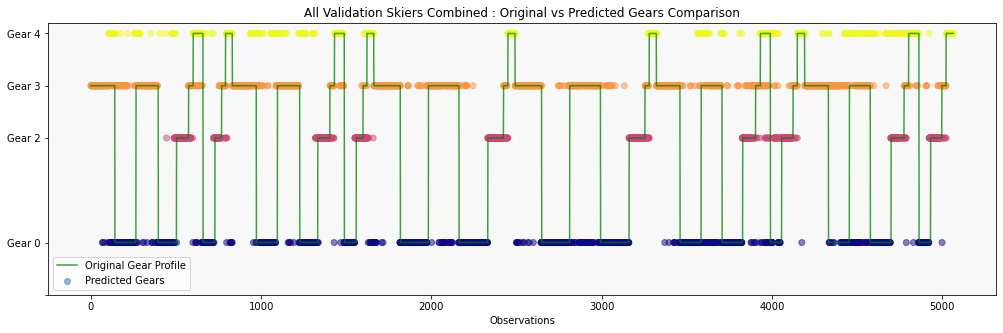

**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [2, 3, 4, 5, 6, 7, 10]
Validation Skiers : [1, 9, 8]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.783,0.681,0.638,0.681,0.654,0.671,0.665



Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.88      0.88      1660
           2       0.65      0.87      0.74       504
           3       0.85      0.75      0.80      2142
           4       0.16      0.22      0.19       249

    accuracy                           0.78      4555
   macro avg       0.64      0.68      0.65      4555
weighted avg       0.80      0.78      0.79      4555



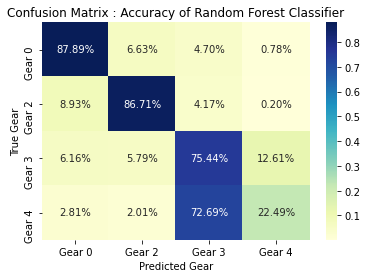

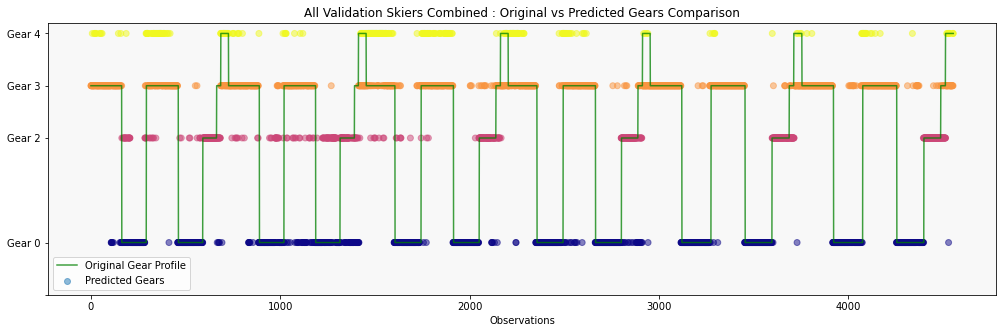

**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [1, 3, 4, 5, 7, 9, 10]
Validation Skiers : [2, 6, 8]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.742,0.673,0.628,0.673,0.644,0.608,0.688



Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      1856
           2       0.64      0.78      0.70       540
           3       0.77      0.69      0.73      2123
           4       0.25      0.38      0.30       250

    accuracy                           0.74      4769
   macro avg       0.63      0.67      0.64      4769
weighted avg       0.76      0.74      0.75      4769



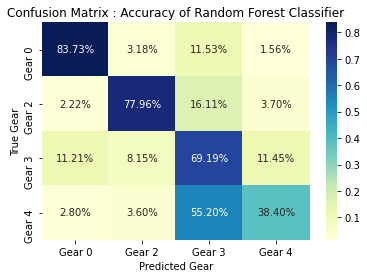

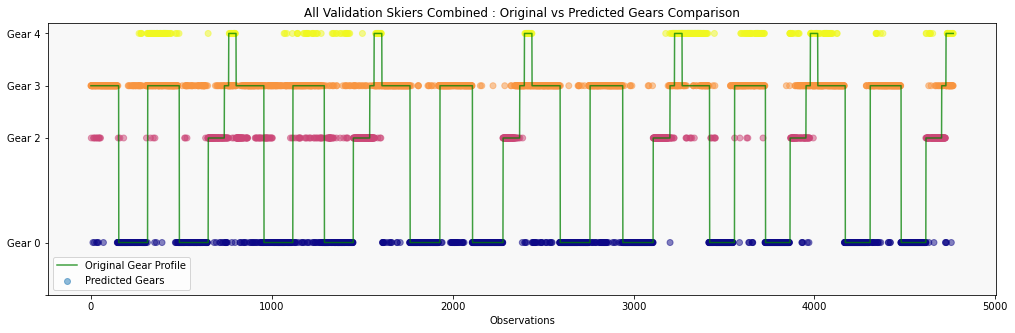

**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [1, 3, 5, 6, 8, 9, 10]
Validation Skiers : [2, 4, 7]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.636,0.626,0.587,0.626,0.594,0.49,0.599



Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.61      0.68      1865
           2       0.55      0.69      0.62       686
           3       0.73      0.66      0.69      1979
           4       0.30      0.53      0.39       486

    accuracy                           0.64      5016
   macro avg       0.59      0.63      0.59      5016
weighted avg       0.68      0.64      0.65      5016



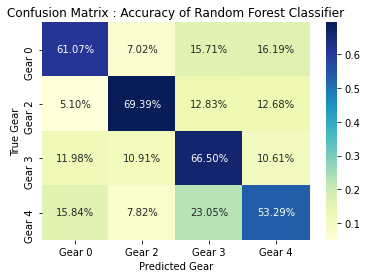

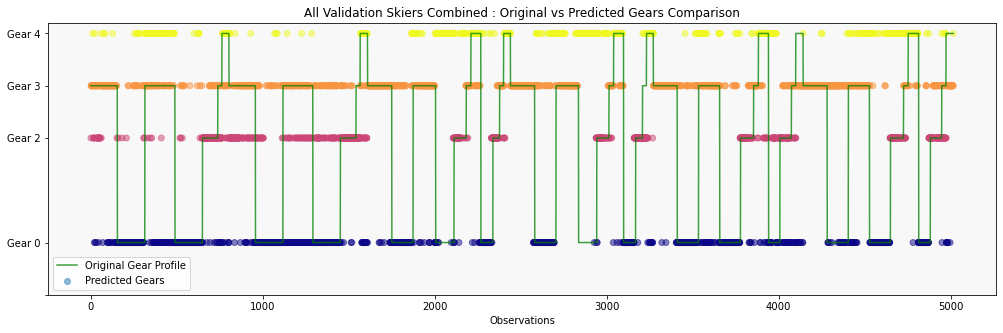

**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [1, 2, 5, 6, 7, 9, 10]
Validation Skiers : [4, 3, 8]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.813,0.786,0.741,0.786,0.759,0.721,0.658



Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.82      0.86      1774
           2       0.73      0.84      0.78       566
           3       0.85      0.83      0.84      2076
           4       0.48      0.66      0.56       357

    accuracy                           0.81      4773
   macro avg       0.74      0.79      0.76      4773
weighted avg       0.83      0.81      0.82      4773



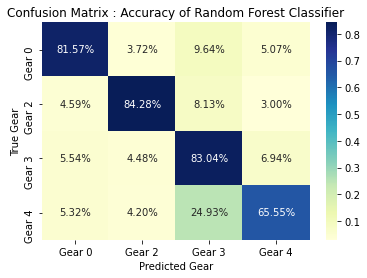

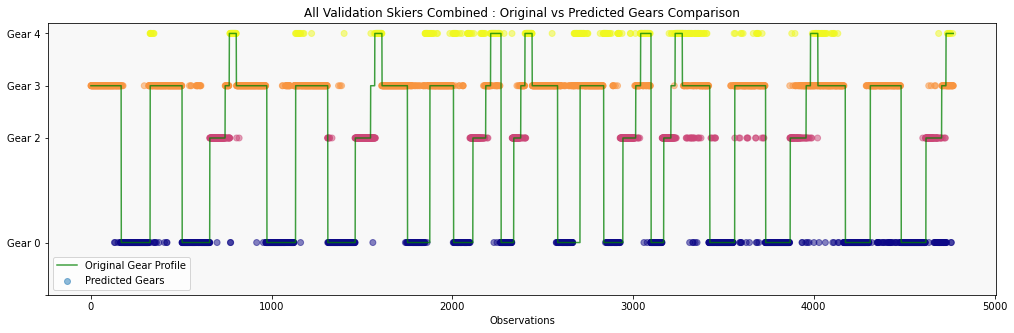

**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [2, 4, 5, 6, 8, 9, 10]
Validation Skiers : [1, 3, 7]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.758,0.719,0.704,0.719,0.709,0.637,0.641



Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.73      0.77      1766
           2       0.67      0.79      0.72       604
           3       0.78      0.81      0.79      2073
           4       0.55      0.55      0.55       367

    accuracy                           0.76      4810
   macro avg       0.70      0.72      0.71      4810
weighted avg       0.76      0.76      0.76      4810



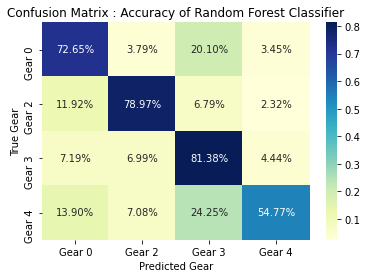

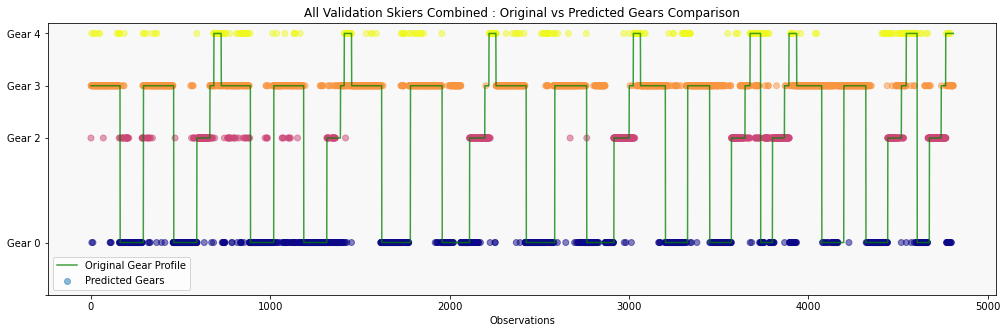

**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [2, 3, 4, 6, 7, 8, 9]
Validation Skiers : [10, 5, 1]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.686,0.671,0.625,0.671,0.642,0.535,0.609



Classification Report: 
               precision    recall  f1-score   support

           0       0.75      0.71      0.73      1726
           2       0.63      0.75      0.68       541
           3       0.73      0.67      0.70      1995
           4       0.38      0.55      0.45       357

    accuracy                           0.69      4619
   macro avg       0.62      0.67      0.64      4619
weighted avg       0.70      0.69      0.69      4619



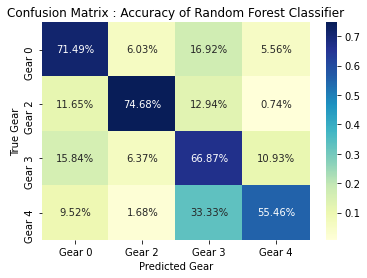

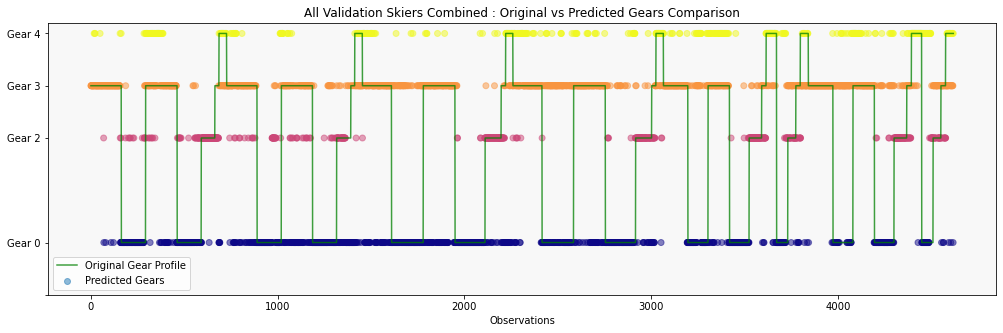

**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [2, 3, 4, 5, 6, 8, 9]
Validation Skiers : [10, 7, 1]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.708,0.703,0.667,0.703,0.68,0.58,0.594



Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.68      0.72      1688
           2       0.64      0.69      0.66       654
           3       0.76      0.74      0.75      1926
           4       0.50      0.70      0.58       484

    accuracy                           0.71      4752
   macro avg       0.67      0.70      0.68      4752
weighted avg       0.72      0.71      0.71      4752



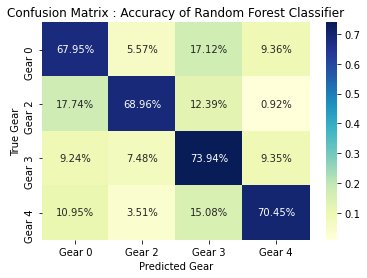

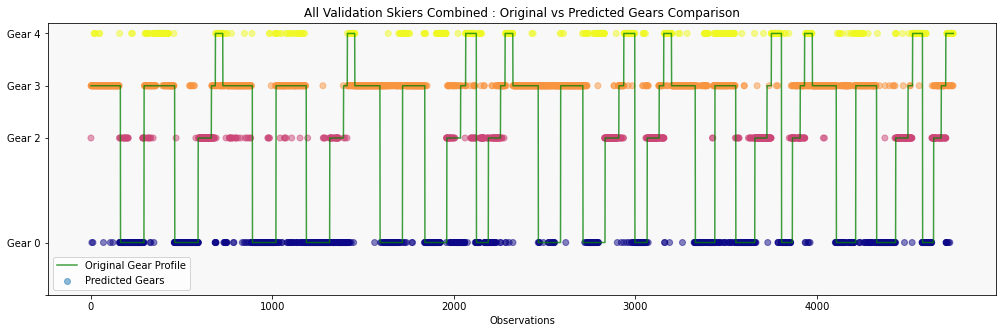

In [5]:
# Create a dataframe that will store data for every run in one table
rfc_results_df = pd.DataFrame(columns=list(['Training Skiers','Validation Skiers',
                                           'Accuracy','Balanced Accuracy','MCC',
                                            'Precision (Macro Avg)','Recall (Macro Avg)',
                                            'F1 (Macro Avg)','Classifier Score',
                                           'Classification Report']))

for i in range(0,10):

    #Load training and validation data based on randomly selected skiers
    X_train, X_valid, y_train, y_valid, y_plot_data, train_skiers_list, val_skiers_list = split_train_test_data(df_info, skier_list, validation_skiers)
    
    display(HTML(f'<p><strong><span style="font-size: 24px; color: rgb(0, 168, 133);">Case {i+1} : Training Skiers : {train_skiers_list}  ||  Validation Skiers : {val_skiers_list}</span></strong></p>'))

    # Evaluate the model using validation data and output performance metrics
    results, all_y_pred, CM_arr, class_report = evaluate(rfc,X_train, y_train,X_valid, y_valid, 'Random Forest Classifier')
    
    
    display(HTML(f'<p><strong><span style="font-size: 20px; color: rgb(239, 239, 239); background-color: rgb(71, 85, 119);">Predicted Gears vs. Original Gears Comparison</span></strong></p>'))
    # Plot the predicted and True gears of validation data to visualize quality of predictions made
    plot_predicted_gear_comparison(y_plot_data,all_y_pred,False)
    
    # Store all results
    temp_all_metrics =  ["" for x in range(10)]
    temp_all_metrics[0] = train_skiers_list
    temp_all_metrics[1] = val_skiers_list
    temp_all_metrics[2] = results[0]
    temp_all_metrics[3] = results[1]
    temp_all_metrics[4] = results[5]
    temp_all_metrics[5] = results[2]
    temp_all_metrics[6] = results[3]
    temp_all_metrics[7] = results[4]
    temp_all_metrics[8] = results[9]
    temp_all_metrics[9] = class_report
    
    rfc_results_df.loc[len(rfc_results_df)] = temp_all_metrics
    
    print('\n\n')
    display(HTML(f'<p><hr></p>'))
    

<a id="rfc_summary"></a>
## Summary of RFC Model Across 10 Runs
[Back To Top](#home)

In [6]:
rfc_results_df

,Training Skiers,Validation Skiers,Accuracy,Balanced Accuracy,MCC,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),Classifier Score,Classification Report
0,"[1, 2, 3, 4, 5, 7, 10]","[6, 9, 8]",0.791,0.750,0.688,0.698,0.750,0.712,0.777,precision recall f1-score ...
1,"[1, 2, 3, 5, 6, 8, 10]","[7, 4, 9]",0.765,0.760,0.666,0.711,0.760,0.728,0.645,precision recall f1-score ...
2,"[1, 2, 3, 5, 8, 9, 10]","[4, 6, 7]",0.786,0.803,0.695,0.747,0.803,0.767,0.554,precision recall f1-score ...
3,"[2, 3, 4, 5, 6, 7, 10]","[1, 9, 8]",0.783,0.681,0.671,0.638,0.681,0.654,0.665,precision recall f1-score ...
4,"[1, 3, 4, 5, 7, 9, 10]","[2, 6, 8]",0.742,0.673,0.608,0.628,0.673,0.644,0.688,precision recall f1-score ...
5,"[1, 3, 5, 6, 8, 9, 10]","[2, 4, 7]",0.636,0.626,0.490,0.587,0.626,0.594,0.599,precision recall f1-score ...
6,"[1, 2, 5, 6, 7, 9, 10]","[4, 3, 8]",0.813,0.786,0.721,0.741,0.786,0.759,0.658,precision recall f1-score ...
7,"[2, 4, 5, 6, 8, 9, 10]","[1, 3, 7]",0.758,0.719,0.637,0.704,0.719,0.709,0.641,precision recall f1-score ...
8,"[2, 3, 4, 6, 7, 8, 9]","[10, 5, 1]",0.686,0.671,0.535,0.625,0.671,0.642,0.609,precision recall f1-score ...
9,"[2, 3, 4, 5, 6, 8, 9]","[10, 7, 1]",0.708,0.703,0.580,0.667,0.703,0.680,0.594,precision recall f1-score ...


In [7]:
rfc_results_df.describe()

,Accuracy,Balanced Accuracy,MCC,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),Classifier Score
count,10.000000,10.00000,10.000000,10.000000,10.00000,10.000000,10.000000
mean,0.746800,0.71720,0.629100,0.674600,0.71720,0.688900,0.643000
std,0.054916,0.05669,0.074905,0.053842,0.05669,0.055776,0.061565
min,0.636000,0.62600,0.490000,0.587000,0.62600,0.594000,0.554000
25%,0.716500,0.67500,0.587000,0.630500,0.67500,0.646500,0.601500
50%,0.761500,0.71100,0.651500,0.682500,0.71100,0.694500,0.643000
75%,0.785250,0.75750,0.683750,0.709250,0.75750,0.724000,0.663250
max,0.813000,0.80300,0.721000,0.747000,0.80300,0.767000,0.777000


<a id="rfc_extra"></a>
## Additional Experiments on Model
[Back To Top](#home)


**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
ADDITIONAL EXPERIMENT!...
Selecting Shortest Skiers for Validation...
Shortest Skiers are also all women, have shortest pole length and lowest mass...
Training Skiers : [1, 2, 3, 5, 6, 8, 9]
Validation Skiers : [10, 7, 4]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.723,0.725,0.693,0.725,0.705,0.609,0.579



Classification Report: 
               precision    recall  f1-score   support

           0       0.75      0.70      0.73      1771
           2       0.67      0.83      0.74       726
           3       0.78      0.73      0.76      1865
           4       0.57      0.64      0.60       598

    accuracy                           0.72      4960
   macro avg       0.69      0.72      0.71      4960
weighted avg       0.73      0.72      0.72      4960



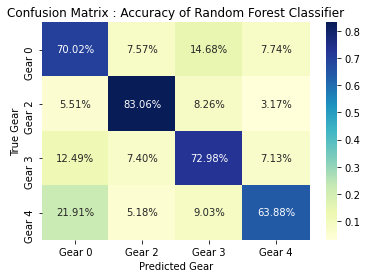

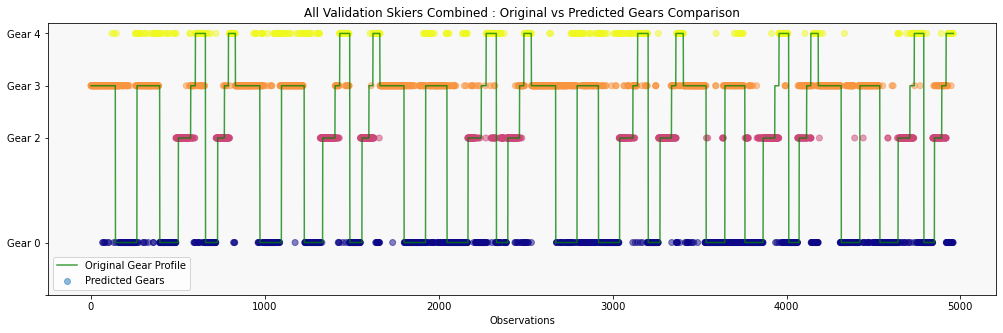

**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
ADDITIONAL EXPERIMENT!...
Selecting Tallest Skiers for Validation...
Tallest Skiers have longest pole length and high mass...
Training Skiers : [4, 5, 6, 7, 8, 9, 10]
Validation Skiers : [1, 2, 3]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.765,0.694,0.659,0.694,0.673,0.634,0.674



Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.83      0.83      1782
           2       0.62      0.68      0.65       499
           3       0.82      0.76      0.79      2148
           4       0.37      0.50      0.43       245

    accuracy                           0.76      4674
   macro avg       0.66      0.69      0.67      4674
weighted avg       0.77      0.76      0.77      4674



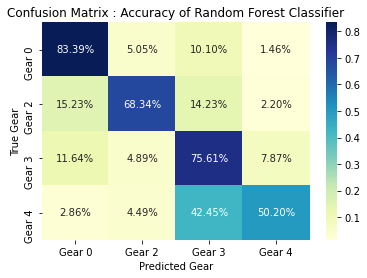

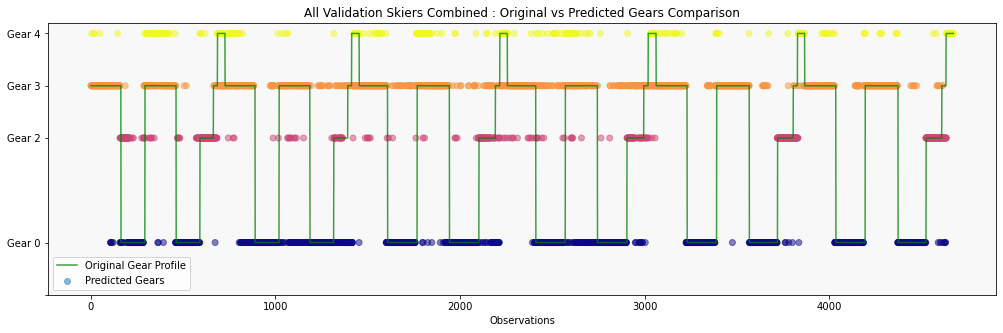

**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
ADDITIONAL EXPERIMENT!...
Selecting Skiers with Lowest Body Mass Index (BMI) for Validation...
Training Skiers : [1, 3, 4, 5, 6, 7]
Validation Skiers : [2, 8, 9, 10]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.753,0.784,0.696,0.784,0.724,0.64,0.657



Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.74      0.79      2328
           2       0.69      0.88      0.77       755
           3       0.79      0.72      0.76      2733
           4       0.45      0.79      0.58       447

    accuracy                           0.75      6263
   macro avg       0.70      0.78      0.72      6263
weighted avg       0.78      0.75      0.76      6263



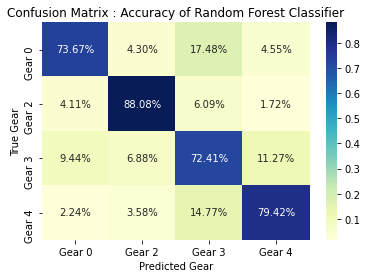

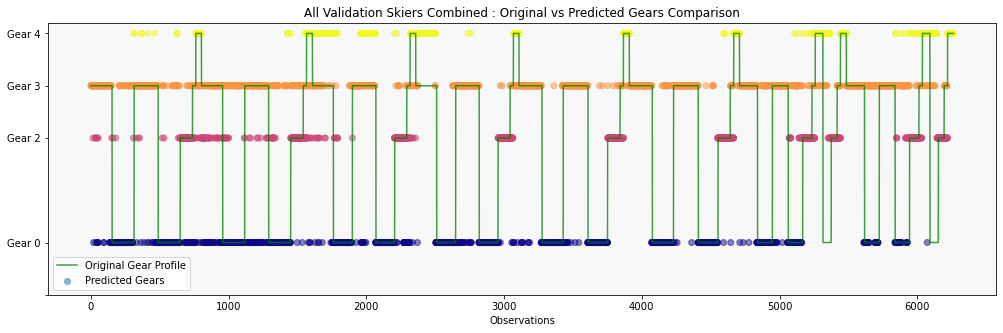

**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
ADDITIONAL EXPERIMENT!...
Selecting Skiers with Highest Body Mass Index (BMI) for Validation...
Training Skiers : [2, 5, 6, 8, 9, 10]
Validation Skiers : [1, 3, 4, 7]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.657,0.618,0.6,0.618,0.607,0.491,0.618



Classification Report: 
               precision    recall  f1-score   support

           0       0.72      0.62      0.66      2367
           2       0.53      0.59      0.56       825
           3       0.70      0.74      0.72      2717
           4       0.45      0.52      0.49       563

    accuracy                           0.66      6472
   macro avg       0.60      0.62      0.61      6472
weighted avg       0.66      0.66      0.66      6472



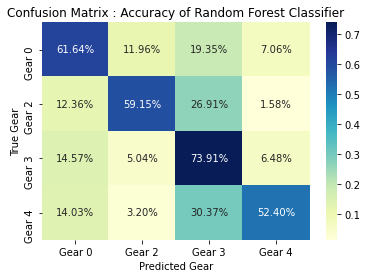

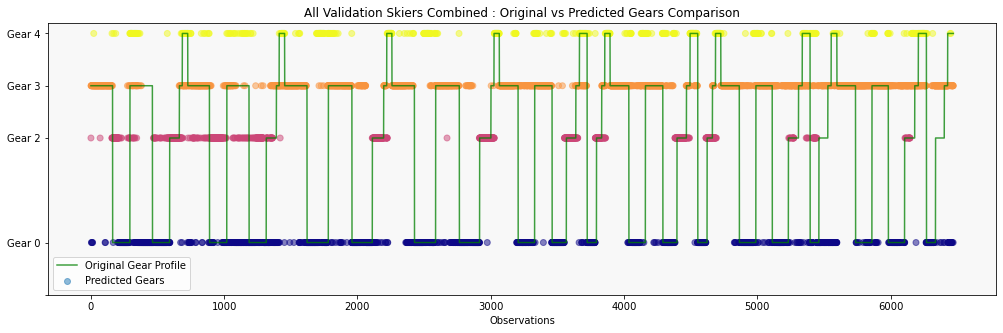

In [8]:
# Create a dataframe that will store data for every run in one table
rfc_results_df = pd.DataFrame(columns=list(['Experiment','Training Skiers','Validation Skiers',
                                           'Accuracy','Balanced Accuracy','MCC',
                                            'Precision (Macro Avg)','Recall (Macro Avg)',
                                            'F1 (Macro Avg)','Classifier Score',
                                           'Classification Report']))

special_cases = ['Selecting All Women Skiers for Validation',
                 'Selecting Tallest Skiers for Validation',
                 'Selecting Skiers with Lowest Body Mass Index (BMI) for Validation',
                 'Selecting Skiers with Highest Body Mass Index (BMI) for Validation']

for i in range(0,len(special_cases)):
    
    #Load training and validation data based on randomly selected skiers
    X_train, X_valid, y_train, y_valid, y_plot_data, train_skiers_list, val_skiers_list = split_train_test_data(df_info, skier_list, validation_skiers, special_case=i)
    
    display(HTML(f'<p><strong><span style="font-size: 24px; color: rgb(0, 168, 133);">Additional Experiment {i+1} :<br> {special_cases[i]} <br>Training Skiers : {train_skiers_list}  ||  Validation Skiers : {val_skiers_list}</span></strong></p>'))
    
    # Evaluate the model using validation data and output performance metrics
    results, all_y_pred, CM_arr, class_report = evaluate(rfc,X_train, y_train,X_valid, y_valid, 'Random Forest Classifier')
    
    # Plot the predicted and True gears of validation data to visualize quality of predictions made
    plot_predicted_gear_comparison(y_plot_data,all_y_pred,False)

    # Store all results
    temp_all_metrics =  ["" for x in range(11)]
    temp_all_metrics[0] = special_cases[i]
    temp_all_metrics[1] = train_skiers_list
    temp_all_metrics[2] = val_skiers_list
    temp_all_metrics[3] = results[0]
    temp_all_metrics[4] = results[1]
    temp_all_metrics[5] = results[5]
    temp_all_metrics[6] = results[2]
    temp_all_metrics[7] = results[3]
    temp_all_metrics[8] = results[4]
    temp_all_metrics[9] = results[9]
    temp_all_metrics[10] = class_report
    
    rfc_results_df.loc[len(rfc_results_df)] = temp_all_metrics
    
    print('\n\n')
    display(HTML(f'<p><hr></p>'))
    

In [9]:
rfc_results_df

,Experiment,Training Skiers,Validation Skiers,Accuracy,Balanced Accuracy,MCC,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),Classifier Score,Classification Report
0,Selecting All Women Skiers for Validation,"[1, 2, 3, 5, 6, 8, 9]","[10, 7, 4]",0.723,0.725,0.609,0.693,0.725,0.705,0.579,precision recall f1-score ...
1,Selecting Tallest Skiers for Validation,"[4, 5, 6, 7, 8, 9, 10]","[1, 2, 3]",0.765,0.694,0.634,0.659,0.694,0.673,0.674,precision recall f1-score ...
2,Selecting Skiers with Lowest Body Mass Index (...,"[1, 3, 4, 5, 6, 7]","[2, 8, 9, 10]",0.753,0.784,0.640,0.696,0.784,0.724,0.657,precision recall f1-score ...
3,Selecting Skiers with Highest Body Mass Index ...,"[2, 5, 6, 8, 9, 10]","[1, 3, 4, 7]",0.657,0.618,0.491,0.600,0.618,0.607,0.618,precision recall f1-score ...


<a id="rfc_obs"></a>
## Observations
[Back To Top](#home)

#### Observations from Cross Validation:
As we can see, the Random Forest Classifier performs well in predicting the gears across all runs on the validation dataset. Across 10 runs, we get a Mean Accuracy of **`0.75`** and a Mean Balanced Accuracy of **`0.72`** with a Mean MCC Score of **`0.630`** which indicates that this is potentially a good classifier for our data. 

The performance of our models in each of the runs varied between 0.64 and 0.82, we have tested this method on different combinations of training and validation sets and can thus be fairly confident that it would perform similarly with somewhat similar performance metrics for any new data we test it on. 

In each of the cases, prediction of Gear 4 was poor, it had the lowest precision among all the gears consistently. This could be due to the fact that it has a considerably smaller set of values in our dataset so the model cannot learn more information about it, and balancing the class weights does not completely rectify the same. 

#### Observations from Additional Experiments:
 Interestingly, our model seems to perform comparatively well when we use only females as our validation dataset. An accuracy of `0.723` is close to the mean accuracy of the model after cross validation, although slightly on the lower side. The females in this experiment also happen to have the lowest mass, shortest height and shortest pole lengths among the skiers we used. Thus we could say this model preforms comparatively well, with slightly reduced accuracy, for skiers with such profiles when trained on skiers that are males, or tall or have higher mass.
 
 Conversely, however, selecting the tallest skiers for validation yielded an improved performance of the model from the mean CV score. An accuracy of `0.76` is slightly higer than the mean, but if we look at the confusion matrix closely for this experiment, we see that the Gear 4 has been predicted very poorly, and the accuracy is potentially skewed due to the high accuracy of gear 0 and gear 3. This is further evidenced bya low Balanced Accuracy of `0.694`and a low F1 Score. 
 
 We also tried to see if a combination of mass and height, such as a body mass index (BMI) calculated as `(mass (in kg))/(height (in m))^2` would impact the accuracy of prediction. We saw that validating on skiers with higher BMI resulted in poor results.


---
---
<a id="refined"></a>
# Refining Predicted Labels using Majority Filter
[Back To Top](#home)


Now, we explore an additional step where we try to refine the results we have obtained. As we saw in the previous section results, each observation in our dataset is being treated individually and returns a label per observations. However, in some areas, we see that the predicted labels are switching between gears very frequently and such high variation in gear in a small window of observations is not realistically possible, as a skier will not be switching between gears so often. 

So, we could potentially further refine our predicted labels by applying a majority filter on the labels. In a majority filter, we define a window size (15 in our case), where for every label, the filter calculates the most commonly occuring label around the current label and updates the current label to that value. This way, if there are outliers within a range of observations, they could be 'corrected' using the majority filter.

This section repeats experiments similar to the above, but in addition also computes the refined results and presents them for side by side comparison. We will discuss our findings at the end of the experiments.

<a id="refined_cv"></a>
## Cross Validation and Refining Predicted Labels
[Back To Top](#home)


**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [1, 2, 3, 6, 7, 8, 9]
Validation Skiers : [4, 5, 10]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.724,0.734,0.686,0.734,0.705,0.601,0.59



Classification Report: 
               precision    recall  f1-score   support

           0       0.76      0.75      0.75      1809
           2       0.69      0.87      0.77       613
           3       0.77      0.67      0.72      1934
           4       0.52      0.64      0.58       471

    accuracy                           0.72      4827
   macro avg       0.69      0.73      0.71      4827
weighted avg       0.73      0.72      0.72      4827



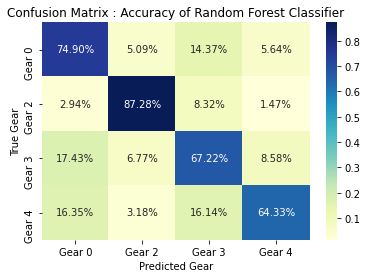

Performance Metrics for Refined Predicted Labels :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC
0,0.794,0.813,0.773,0.813,0.788,0.702



Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.82      0.81      1809
           2       0.71      0.94      0.81       613
           3       0.85      0.73      0.78      1934
           4       0.74      0.76      0.75       471

    accuracy                           0.79      4827
   macro avg       0.77      0.81      0.79      4827
weighted avg       0.80      0.79      0.79      4827



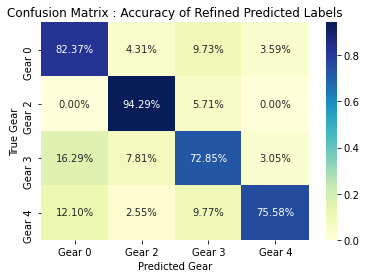

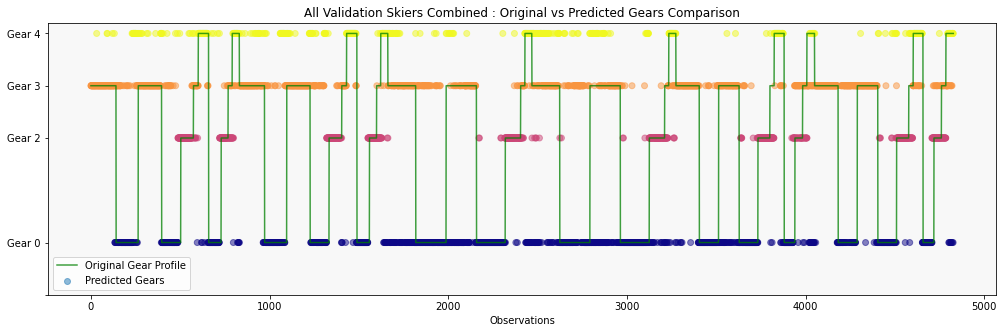

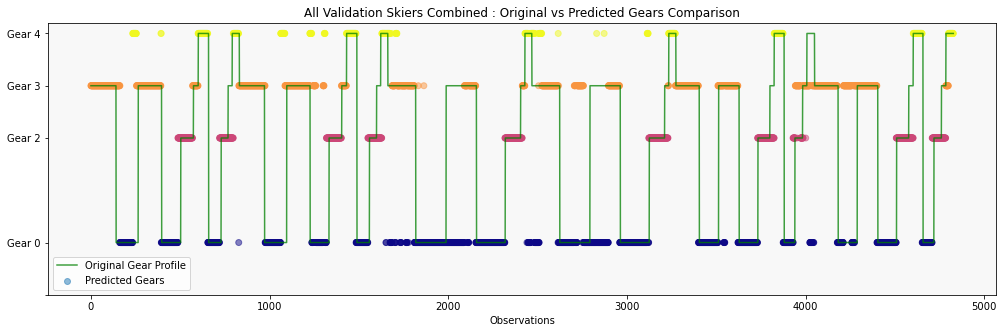

**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [1, 2, 5, 6, 7, 8, 10]
Validation Skiers : [9, 3, 4]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.823,0.805,0.743,0.805,0.765,0.739,0.711



Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.79      0.84      1818
           2       0.76      0.91      0.83       571
           3       0.91      0.85      0.88      2125
           4       0.42      0.67      0.52       360

    accuracy                           0.82      4874
   macro avg       0.74      0.81      0.76      4874
weighted avg       0.85      0.82      0.83      4874



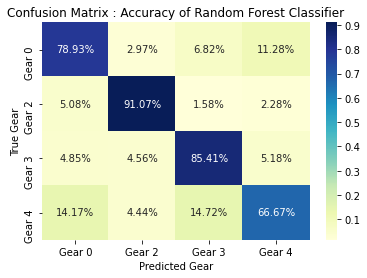

Performance Metrics for Refined Predicted Labels :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC
0,0.863,0.854,0.785,0.854,0.81,0.798



Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.80      0.86      1818
           2       0.77      0.99      0.87       571
           3       0.93      0.91      0.92      2125
           4       0.50      0.72      0.59       360

    accuracy                           0.86      4874
   macro avg       0.79      0.85      0.81      4874
weighted avg       0.88      0.86      0.87      4874



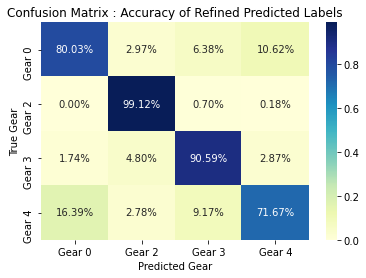

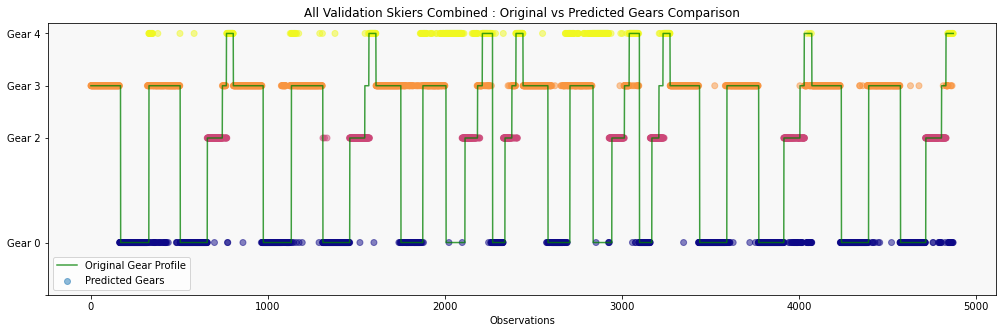

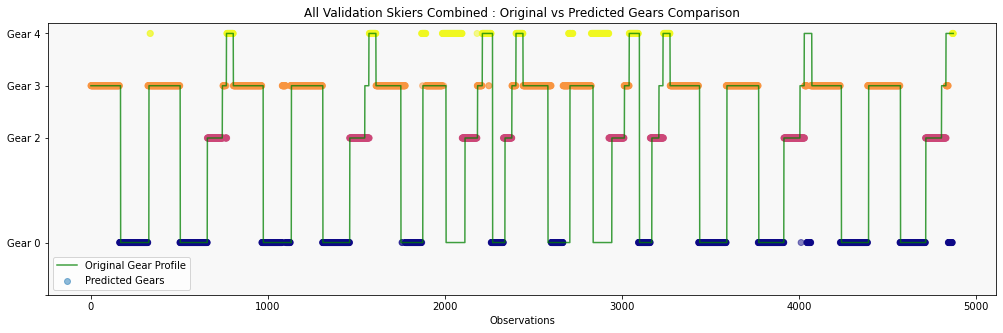

**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [1, 3, 4, 5, 6, 9, 10]
Validation Skiers : [7, 2, 8]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.699,0.654,0.622,0.654,0.633,0.558,0.649



Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.73      0.78      1813
           2       0.58      0.69      0.63       640
           3       0.73      0.71      0.72      2029
           4       0.34      0.49      0.40       372

    accuracy                           0.70      4854
   macro avg       0.62      0.65      0.63      4854
weighted avg       0.72      0.70      0.71      4854



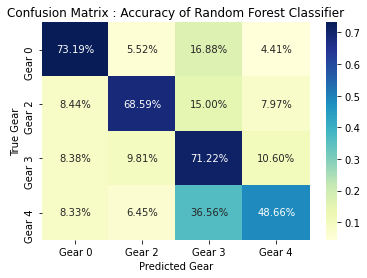

Performance Metrics for Refined Predicted Labels :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC
0,0.801,0.747,0.727,0.747,0.735,0.703



Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.84      0.88      1813
           2       0.69      0.83      0.76       640
           3       0.80      0.82      0.81      2029
           4       0.49      0.51      0.50       372

    accuracy                           0.80      4854
   macro avg       0.73      0.75      0.73      4854
weighted avg       0.81      0.80      0.80      4854



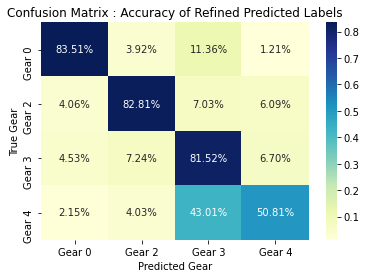

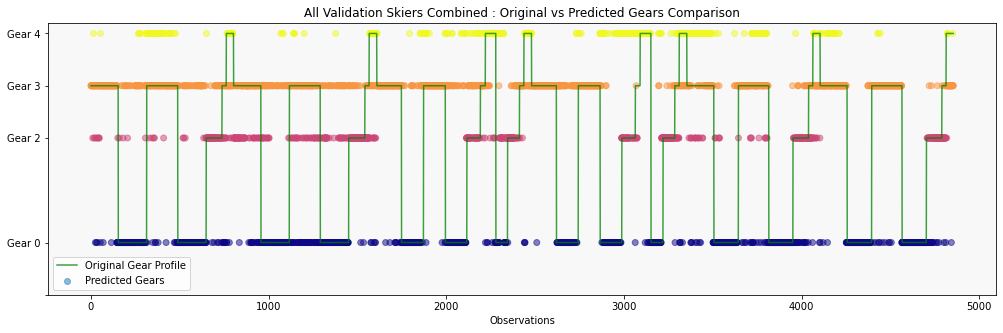

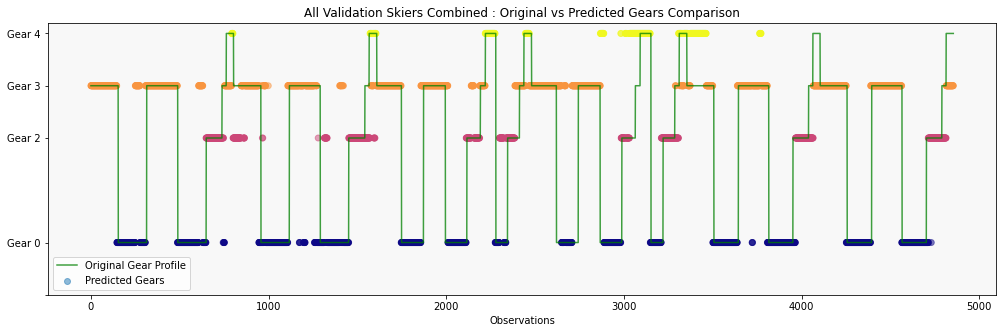

**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [2, 3, 4, 6, 7, 9, 10]
Validation Skiers : [8, 1, 5]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.728,0.675,0.617,0.675,0.637,0.588,0.523



Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.79      0.80      1729
           2       0.60      0.80      0.69       496
           3       0.79      0.70      0.74      2098
           4       0.25      0.42      0.31       243

    accuracy                           0.73      4566
   macro avg       0.62      0.68      0.64      4566
weighted avg       0.75      0.73      0.74      4566



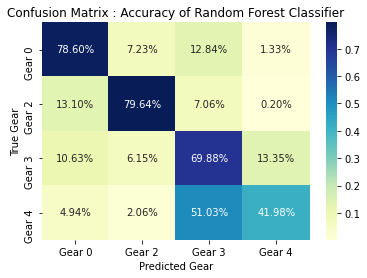

Performance Metrics for Refined Predicted Labels :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC
0,0.814,0.748,0.7,0.748,0.72,0.714



Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      1729
           2       0.71      0.90      0.79       496
           3       0.86      0.80      0.83      2098
           4       0.35      0.43      0.39       243

    accuracy                           0.81      4566
   macro avg       0.70      0.75      0.72      4566
weighted avg       0.83      0.81      0.82      4566



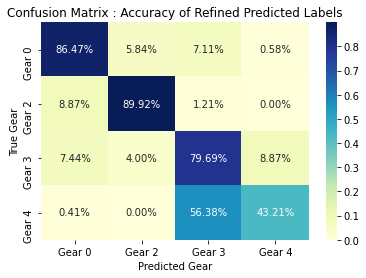

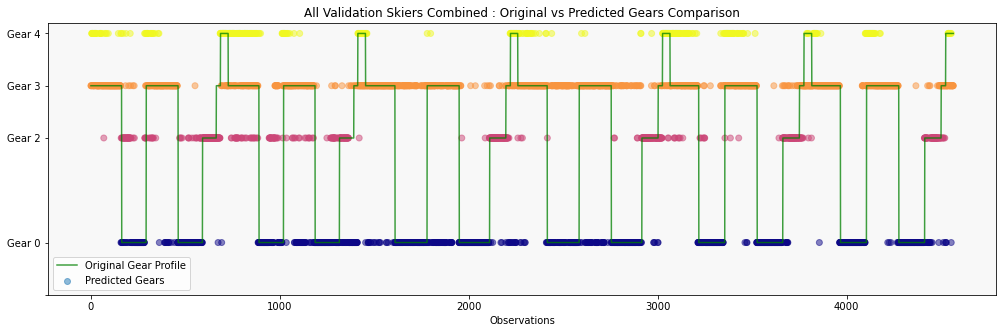

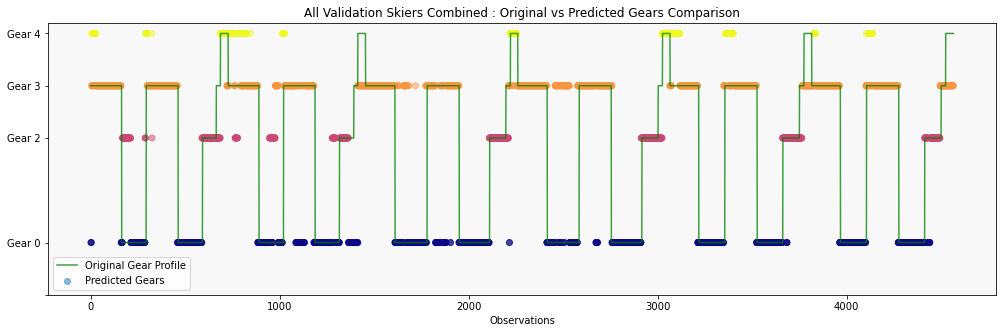

**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [2, 4, 5, 6, 8, 9, 10]
Validation Skiers : [1, 7, 3]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.754,0.714,0.697,0.714,0.704,0.629,0.641



Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.73      0.77      1766
           2       0.67      0.79      0.73       604
           3       0.77      0.80      0.79      2073
           4       0.52      0.54      0.53       367

    accuracy                           0.75      4810
   macro avg       0.70      0.71      0.70      4810
weighted avg       0.76      0.75      0.75      4810



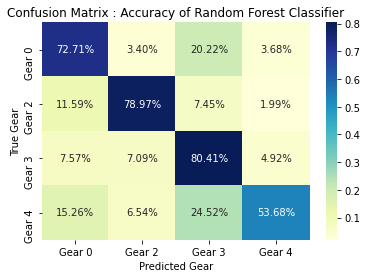

Performance Metrics for Refined Predicted Labels :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC
0,0.822,0.772,0.815,0.772,0.785,0.729



Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.78      0.82      1766
           2       0.75      0.85      0.80       604
           3       0.82      0.89      0.85      2073
           4       0.83      0.56      0.67       367

    accuracy                           0.82      4810
   macro avg       0.82      0.77      0.79      4810
weighted avg       0.82      0.82      0.82      4810



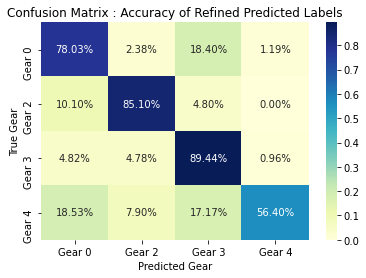

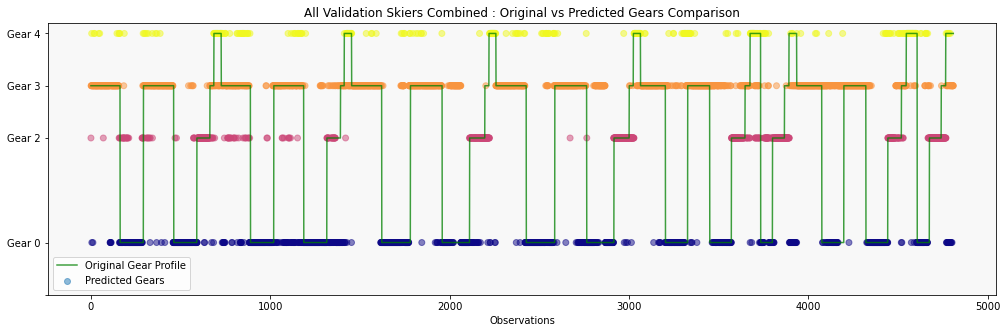

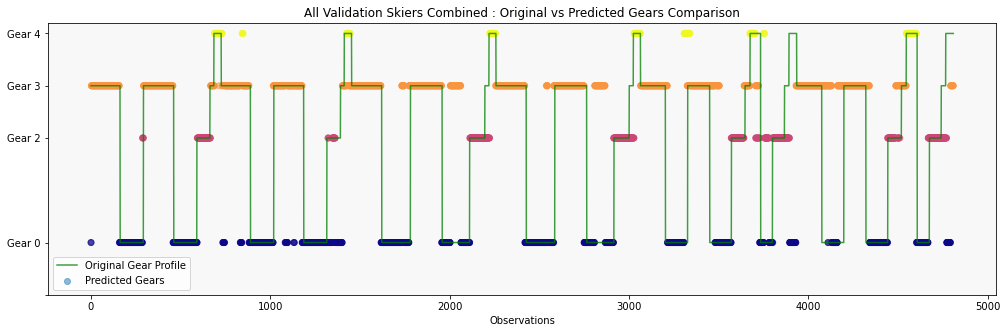

**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [1, 3, 5, 6, 7, 9, 10]
Validation Skiers : [4, 8, 2]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.749,0.727,0.673,0.727,0.692,0.631,0.617



Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.75      0.81      1790
           2       0.62      0.85      0.72       576
           3       0.79      0.75      0.77      2043
           4       0.42      0.55      0.48       362

    accuracy                           0.75      4771
   macro avg       0.67      0.73      0.69      4771
weighted avg       0.77      0.75      0.75      4771



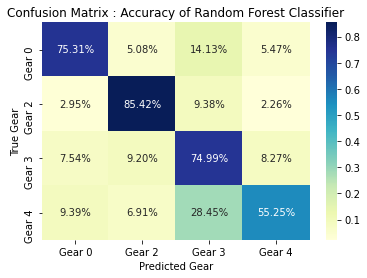

Performance Metrics for Refined Predicted Labels :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC
0,0.843,0.806,0.759,0.806,0.776,0.767



Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.86      0.90      1790
           2       0.71      0.98      0.83       576
           3       0.88      0.84      0.86      2043
           4       0.50      0.54      0.52       362

    accuracy                           0.84      4771
   macro avg       0.76      0.81      0.78      4771
weighted avg       0.85      0.84      0.85      4771



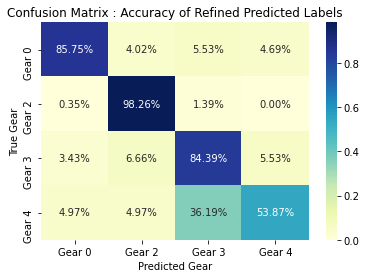

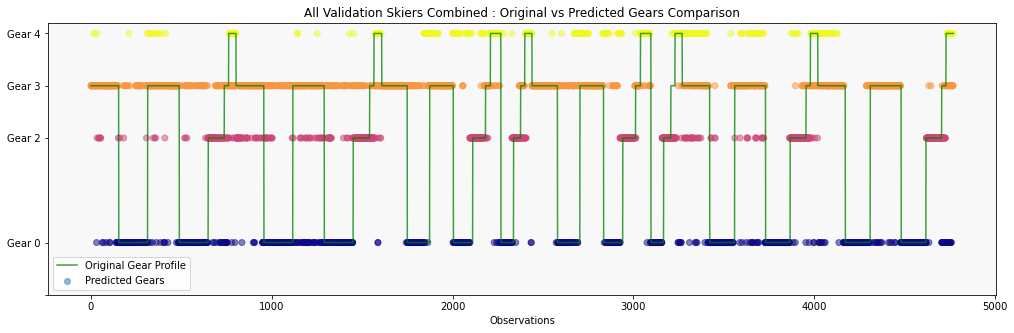

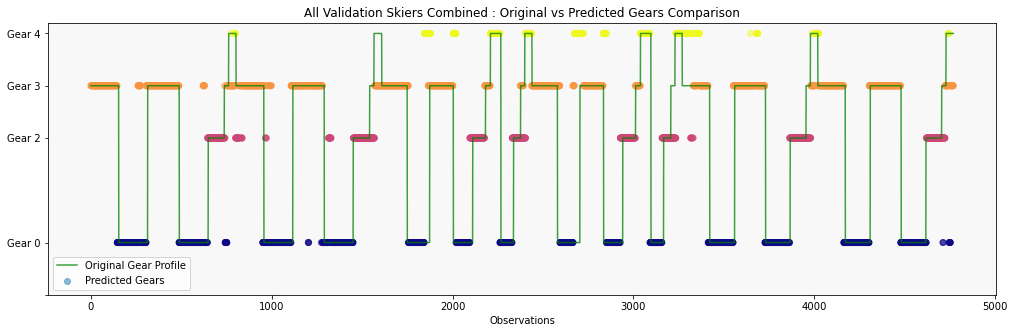

**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [4, 5, 6, 7, 8, 9, 10]
Validation Skiers : [3, 2, 1]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.766,0.692,0.661,0.692,0.674,0.634,0.677



Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.84      0.82      1782
           2       0.63      0.66      0.64       499
           3       0.83      0.76      0.79      2148
           4       0.38      0.51      0.44       245

    accuracy                           0.77      4674
   macro avg       0.66      0.69      0.67      4674
weighted avg       0.77      0.77      0.77      4674



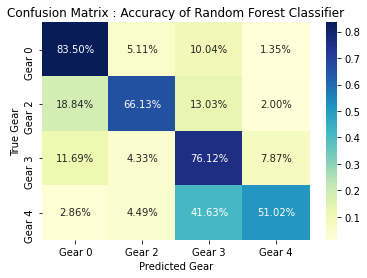

Performance Metrics for Refined Predicted Labels :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC
0,0.843,0.741,0.782,0.741,0.756,0.75



Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.92      0.88      1782
           2       0.73      0.74      0.73       499
           3       0.89      0.84      0.86      2148
           4       0.67      0.46      0.54       245

    accuracy                           0.84      4674
   macro avg       0.78      0.74      0.76      4674
weighted avg       0.84      0.84      0.84      4674



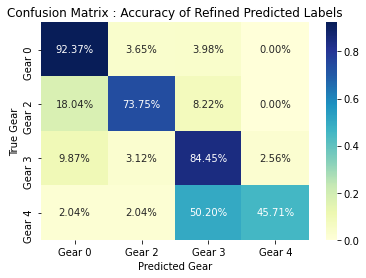

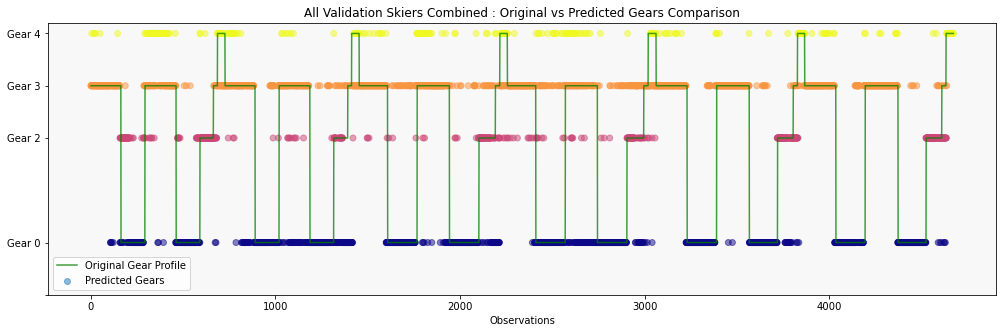

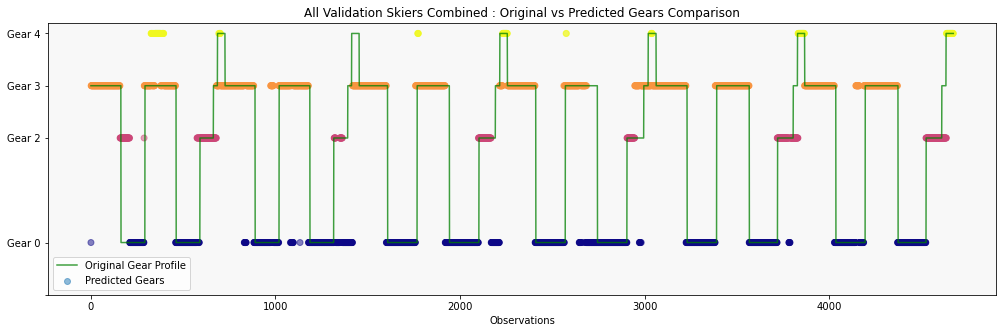

**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [1, 2, 3, 4, 5, 7, 10]
Validation Skiers : [9, 6, 8]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.784,0.74,0.691,0.74,0.704,0.676,0.769



Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.92      0.89      1809
           2       0.82      0.87      0.84       540
           3       0.83      0.68      0.75      2161
           4       0.26      0.49      0.34       251

    accuracy                           0.78      4761
   macro avg       0.69      0.74      0.70      4761
weighted avg       0.81      0.78      0.79      4761



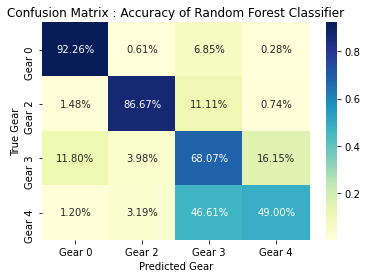

Performance Metrics for Refined Predicted Labels :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC
0,0.812,0.759,0.715,0.759,0.723,0.725



Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      1809
           2       0.87      0.93      0.90       540
           3       0.88      0.69      0.77      2161
           4       0.21      0.44      0.29       251

    accuracy                           0.81      4761
   macro avg       0.71      0.76      0.72      4761
weighted avg       0.85      0.81      0.82      4761



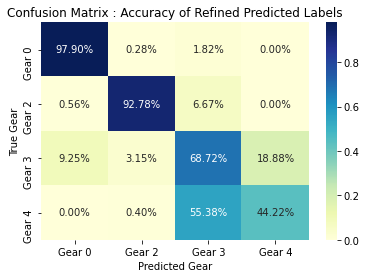

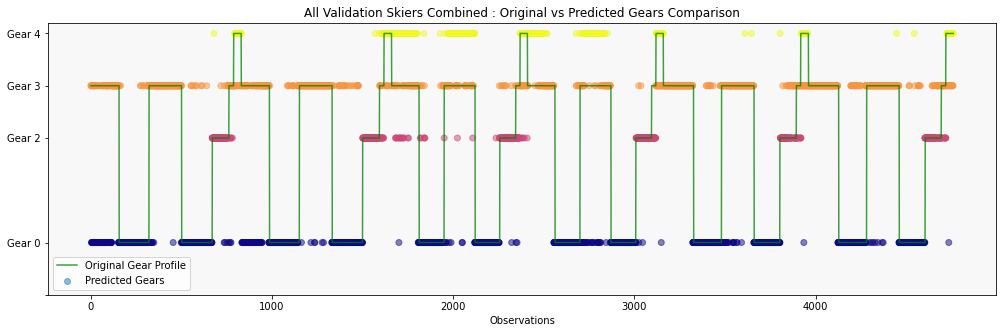

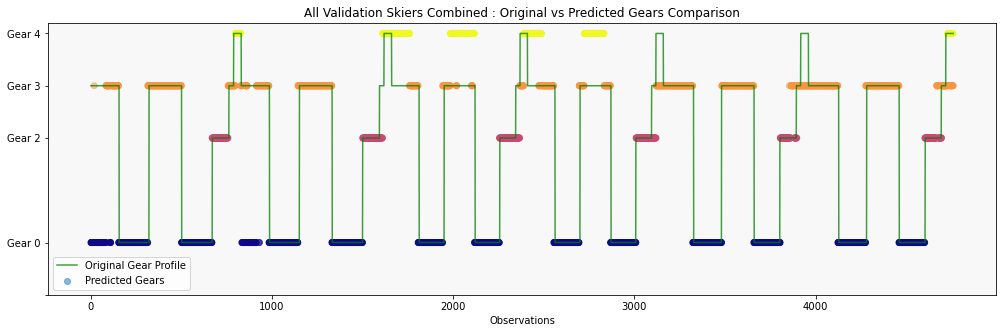

**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [1, 2, 3, 5, 7, 8, 9]
Validation Skiers : [4, 10, 6]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.808,0.802,0.757,0.802,0.776,0.722,0.647



Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.80      0.83      1814
           2       0.71      0.88      0.79       626
           3       0.87      0.81      0.84      1959
           4       0.59      0.72      0.65       476

    accuracy                           0.81      4875
   macro avg       0.76      0.80      0.78      4875
weighted avg       0.82      0.81      0.81      4875



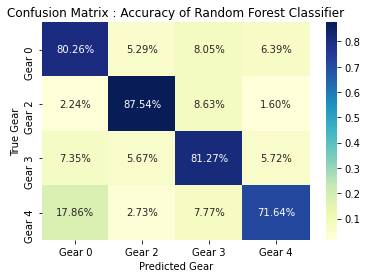

Performance Metrics for Refined Predicted Labels :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC
0,0.885,0.88,0.85,0.88,0.861,0.833



Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.87      0.90      1814
           2       0.73      0.96      0.83       626
           3       0.93      0.90      0.91      1959
           4       0.81      0.80      0.80       476

    accuracy                           0.88      4875
   macro avg       0.85      0.88      0.86      4875
weighted avg       0.89      0.88      0.89      4875



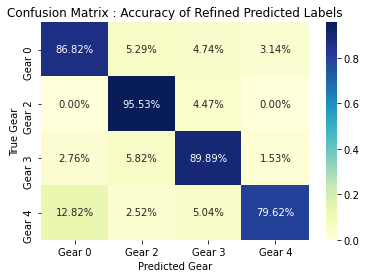

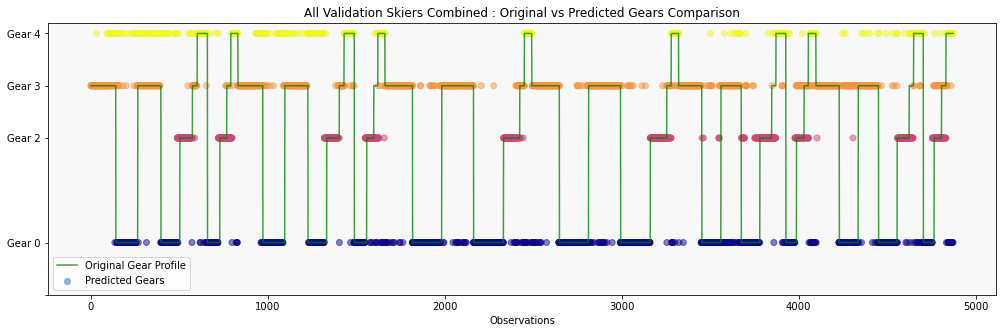

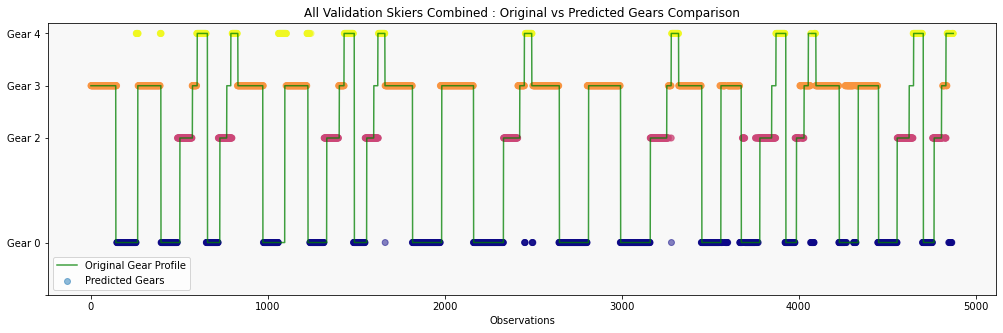

**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
Training Skiers : [1, 2, 3, 7, 8, 9, 10]
Validation Skiers : [4, 6, 5]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.734,0.736,0.683,0.736,0.702,0.608,0.587



Classification Report: 
               precision    recall  f1-score   support

           0       0.74      0.80      0.77      1930
           2       0.76      0.89      0.82       578
           3       0.81      0.65      0.72      2067
           4       0.42      0.60      0.49       359

    accuracy                           0.73      4934
   macro avg       0.68      0.74      0.70      4934
weighted avg       0.75      0.73      0.74      4934



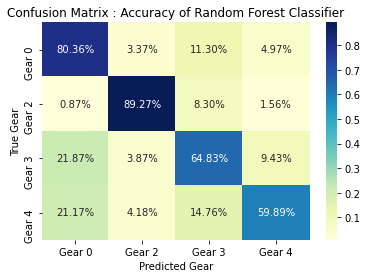

Performance Metrics for Refined Predicted Labels :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC
0,0.798,0.805,0.755,0.805,0.771,0.705



Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.88      0.82      1930
           2       0.82      0.97      0.89       578
           3       0.92      0.70      0.79      2067
           4       0.52      0.68      0.59       359

    accuracy                           0.80      4934
   macro avg       0.75      0.81      0.77      4934
weighted avg       0.82      0.80      0.80      4934



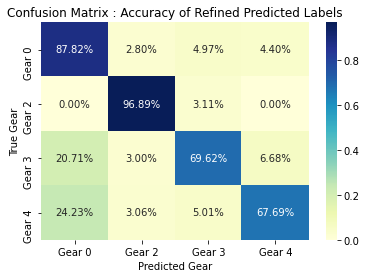

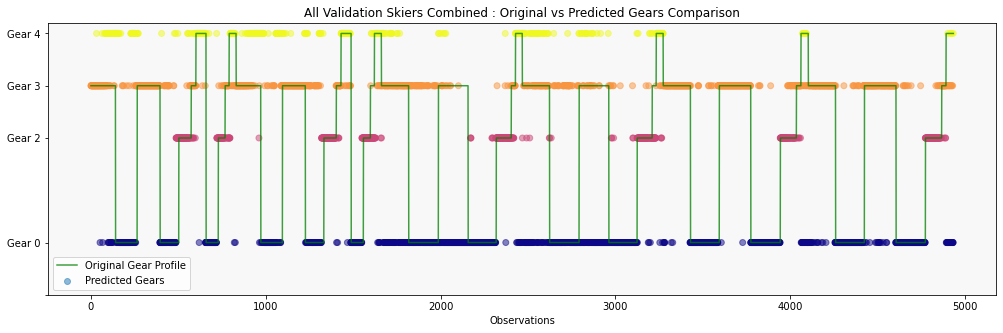

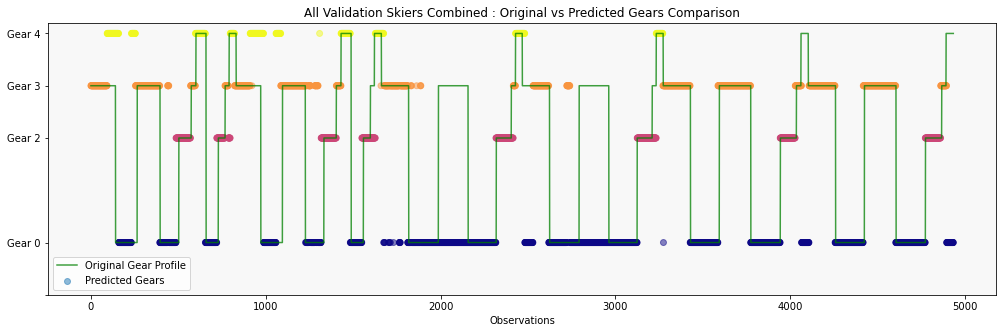

In [10]:
# Create a dataframe that will store data for every run in one table
rfc_results_df = pd.DataFrame(columns=list(['Training Skiers','Validation Skiers',
                                           'Accuracy','Balanced Accuracy','MCC',
                                            'Precision (Macro Avg)','Recall (Macro Avg)',
                                            'F1 (Macro Avg)',
                                           'Classification Report']))

refined_results_df = pd.DataFrame(columns=list(['Training Skiers','Validation Skiers',
                                           'Accuracy','Balanced Accuracy','MCC',
                                            'Precision (Macro Avg)','Recall (Macro Avg)',
                                            'F1 (Macro Avg)',
                                           'Classification Report']))


for i in range(0,10):

    #Load training and validation data based on randomly selected skiers
    X_train, X_valid, y_train, y_valid, y_plot_data, train_skiers_list, val_skiers_list = split_train_test_data(df_info, skier_list, validation_skiers)
    
    display(HTML(f'<p><strong><span style="font-size: 24px; color: rgb(0, 168, 133);">Case {i+1} : Training Skiers : {train_skiers_list}  ||  Validation Skiers : {val_skiers_list}</span></strong></p>'))

    display(HTML(f'<p><em><strong><span style="font-size: 20px; background-color: rgb(251, 160, 38);">Original Results&nbsp;</span></strong></em></p>'))
    # Evaluate the model using validation data and output performance metrics
    results, all_y_pred, CM_arr, class_report = evaluate(rfc,X_train, y_train,X_valid, y_valid, 'Random Forest Classifier')
    
    display(HTML(f'<p><em><strong><span style="font-size: 20px; background-color: rgb(251, 160, 38);">Refined Results&nbsp;</span></strong></em></p>'))
    refined_results, refined_all_y_pred, refined_CM_arr, refined_class_report = refine_predicted_labels(y_valid, all_y_pred, 'Refined Predicted Labels')
    
    display(HTML(f'<p><strong><span style="font-size: 20px; color: rgb(239, 239, 239); background-color: rgb(71, 85, 119);"><u>ORIGINAL RESULTS</u> : Predicted Gears vs. Original Gears Comparison</span></strong></p>'))
    # Plot the predicted and True gears of validation data to visualize quality of predictions made
    plot_predicted_gear_comparison(y_plot_data,all_y_pred,False)
    
    display(HTML(f'<p><strong><span style="font-size: 20px; color: rgb(239, 239, 239); background-color: rgb(71, 85, 119);"><u>REFINED RESULTS</u> : Predicted Gears vs. Original Gears Comparison</span></strong></p>'))
    plot_predicted_gear_comparison(y_plot_data,refined_all_y_pred,False)
    
    
    # Store all results
    temp_all_metrics =  ["" for x in range(9)]
    temp_all_metrics[0] = train_skiers_list
    temp_all_metrics[1] = val_skiers_list
    temp_all_metrics[2] = results[0]
    temp_all_metrics[3] = results[1]
    temp_all_metrics[4] = results[5]
    temp_all_metrics[5] = results[2]
    temp_all_metrics[6] = results[3]
    temp_all_metrics[7] = results[4]
    temp_all_metrics[8] = class_report

    rfc_results_df.loc[len(rfc_results_df)] = temp_all_metrics

    # Store all refined results
    temp_all_metrics =  ["" for x in range(9)]
    temp_all_metrics[0] = train_skiers_list
    temp_all_metrics[1] = val_skiers_list
    temp_all_metrics[2] = refined_results[0]
    temp_all_metrics[3] = refined_results[1]
    temp_all_metrics[4] = refined_results[5]
    temp_all_metrics[5] = refined_results[2]
    temp_all_metrics[6] = refined_results[3]
    temp_all_metrics[7] = refined_results[4]
    temp_all_metrics[8] = class_report

    refined_results_df.loc[len(refined_results_df)] = temp_all_metrics
    
    print('\n\n')
    display(HTML(f'<p><hr></p>'))
    

<a id="refined_summary"></a>
## Summary of Cross Validation and Comparison of Refined Predicted Labels
[Back To Top](#home)

#### Original Results

In [11]:
rfc_results_df

,Training Skiers,Validation Skiers,Accuracy,Balanced Accuracy,MCC,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),Classification Report
0,"[1, 2, 3, 6, 7, 8, 9]","[4, 5, 10]",0.724,0.734,0.601,0.686,0.734,0.705,precision recall f1-score ...
1,"[1, 2, 5, 6, 7, 8, 10]","[9, 3, 4]",0.823,0.805,0.739,0.743,0.805,0.765,precision recall f1-score ...
2,"[1, 3, 4, 5, 6, 9, 10]","[7, 2, 8]",0.699,0.654,0.558,0.622,0.654,0.633,precision recall f1-score ...
3,"[2, 3, 4, 6, 7, 9, 10]","[8, 1, 5]",0.728,0.675,0.588,0.617,0.675,0.637,precision recall f1-score ...
4,"[2, 4, 5, 6, 8, 9, 10]","[1, 7, 3]",0.754,0.714,0.629,0.697,0.714,0.704,precision recall f1-score ...
5,"[1, 3, 5, 6, 7, 9, 10]","[4, 8, 2]",0.749,0.727,0.631,0.673,0.727,0.692,precision recall f1-score ...
6,"[4, 5, 6, 7, 8, 9, 10]","[3, 2, 1]",0.766,0.692,0.634,0.661,0.692,0.674,precision recall f1-score ...
7,"[1, 2, 3, 4, 5, 7, 10]","[9, 6, 8]",0.784,0.740,0.676,0.691,0.740,0.704,precision recall f1-score ...
8,"[1, 2, 3, 5, 7, 8, 9]","[4, 10, 6]",0.808,0.802,0.722,0.757,0.802,0.776,precision recall f1-score ...
9,"[1, 2, 3, 7, 8, 9, 10]","[4, 6, 5]",0.734,0.736,0.608,0.683,0.736,0.702,precision recall f1-score ...


In [12]:
rfc_results_df.describe()

,Accuracy,Balanced Accuracy,MCC,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg)
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.756900,0.727900,0.638600,0.683000,0.727900,0.699200
std,0.038963,0.048793,0.057747,0.044729,0.048793,0.046252
min,0.699000,0.654000,0.558000,0.617000,0.654000,0.633000
25%,0.729500,0.697500,0.602750,0.664000,0.697500,0.678500
50%,0.751500,0.730500,0.630000,0.684500,0.730500,0.703000
75%,0.779500,0.739000,0.665500,0.695500,0.739000,0.704750
max,0.823000,0.805000,0.739000,0.757000,0.805000,0.776000


#### Refined Results

In [13]:
refined_results_df

,Training Skiers,Validation Skiers,Accuracy,Balanced Accuracy,MCC,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),Classification Report
0,"[1, 2, 3, 6, 7, 8, 9]","[4, 5, 10]",0.794,0.813,0.702,0.773,0.813,0.788,precision recall f1-score ...
1,"[1, 2, 5, 6, 7, 8, 10]","[9, 3, 4]",0.863,0.854,0.798,0.785,0.854,0.810,precision recall f1-score ...
2,"[1, 3, 4, 5, 6, 9, 10]","[7, 2, 8]",0.801,0.747,0.703,0.727,0.747,0.735,precision recall f1-score ...
3,"[2, 3, 4, 6, 7, 9, 10]","[8, 1, 5]",0.814,0.748,0.714,0.700,0.748,0.720,precision recall f1-score ...
4,"[2, 4, 5, 6, 8, 9, 10]","[1, 7, 3]",0.822,0.772,0.729,0.815,0.772,0.785,precision recall f1-score ...
5,"[1, 3, 5, 6, 7, 9, 10]","[4, 8, 2]",0.843,0.806,0.767,0.759,0.806,0.776,precision recall f1-score ...
6,"[4, 5, 6, 7, 8, 9, 10]","[3, 2, 1]",0.843,0.741,0.750,0.782,0.741,0.756,precision recall f1-score ...
7,"[1, 2, 3, 4, 5, 7, 10]","[9, 6, 8]",0.812,0.759,0.725,0.715,0.759,0.723,precision recall f1-score ...
8,"[1, 2, 3, 5, 7, 8, 9]","[4, 10, 6]",0.885,0.880,0.833,0.850,0.880,0.861,precision recall f1-score ...
9,"[1, 2, 3, 7, 8, 9, 10]","[4, 6, 5]",0.798,0.805,0.705,0.755,0.805,0.771,precision recall f1-score ...


In [14]:
refined_results_df.describe()

,Accuracy,Balanced Accuracy,MCC,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg)
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.827500,0.792500,0.742600,0.766100,0.792500,0.772500
std,0.030174,0.047659,0.044515,0.045669,0.047659,0.042862
min,0.794000,0.741000,0.702000,0.700000,0.741000,0.720000
25%,0.803750,0.750750,0.707250,0.734000,0.750750,0.740250
50%,0.818000,0.788500,0.727000,0.766000,0.788500,0.773500
75%,0.843000,0.811250,0.762750,0.784250,0.811250,0.787250
max,0.885000,0.880000,0.833000,0.850000,0.880000,0.861000


### Observations From CV and Refining Predicted Labels

It is clear from the above that there is a visible improvement in accuracy of the results when we remove/modify teh outliers within a range of observations for a gear using the majority filter. The Mean accuracy jumps from `0.756` to `0.827` and the balanced accuracy improves from `0.727` to `0.792`. 

Currently the window width for the filter is 15 neighboring values by little trial and error, but maybe by playing around with that width parameter further, we could increase the performance further.

<a id="refined_extra"></a>
## Refined Results for Additional Expermients
[Back To Top](#home)


**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
ADDITIONAL EXPERIMENT!...
Selecting Shortest Skiers for Validation...
Shortest Skiers are also all women, have shortest pole length and lowest mass...
Training Skiers : [1, 2, 3, 5, 6, 8, 9]
Validation Skiers : [10, 7, 4]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.725,0.728,0.695,0.728,0.708,0.613,0.57



Classification Report: 
               precision    recall  f1-score   support

           0       0.75      0.70      0.73      1771
           2       0.67      0.83      0.74       726
           3       0.79      0.73      0.76      1865
           4       0.56      0.64      0.60       598

    accuracy                           0.73      4960
   macro avg       0.69      0.73      0.71      4960
weighted avg       0.73      0.73      0.73      4960



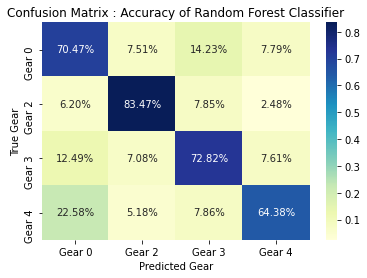

Performance Metrics for Refined Predicted Labels :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC
0,0.804,0.807,0.785,0.807,0.791,0.723



Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.78      0.80      1771
           2       0.69      0.92      0.79       726
           3       0.86      0.81      0.83      1865
           4       0.76      0.72      0.74       598

    accuracy                           0.80      4960
   macro avg       0.78      0.81      0.79      4960
weighted avg       0.81      0.80      0.80      4960



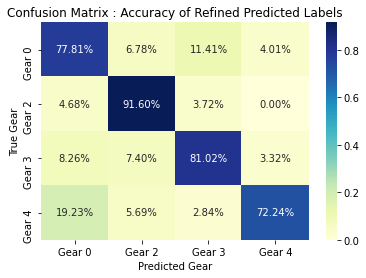

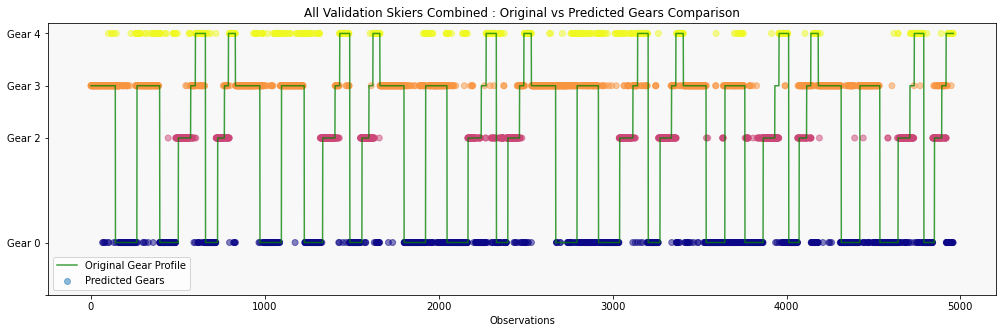

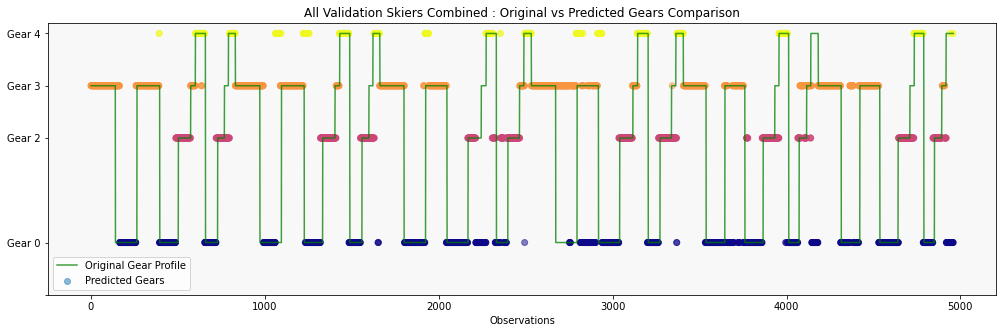

**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
ADDITIONAL EXPERIMENT!...
Selecting Tallest Skiers for Validation...
Tallest Skiers have longest pole length and high mass...
Training Skiers : [4, 5, 6, 7, 8, 9, 10]
Validation Skiers : [1, 2, 3]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.763,0.694,0.659,0.694,0.674,0.631,0.666



Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.83      0.82      1782
           2       0.62      0.68      0.65       499
           3       0.82      0.75      0.79      2148
           4       0.38      0.51      0.44       245

    accuracy                           0.76      4674
   macro avg       0.66      0.69      0.67      4674
weighted avg       0.77      0.76      0.77      4674



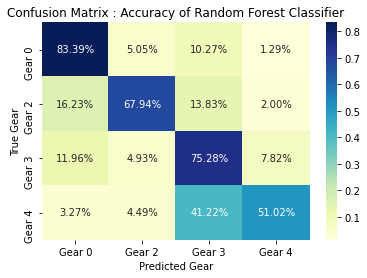

Performance Metrics for Refined Predicted Labels :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC
0,0.841,0.741,0.795,0.741,0.757,0.748



Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.92      0.88      1782
           2       0.73      0.79      0.76       499
           3       0.88      0.84      0.86      2148
           4       0.73      0.42      0.53       245

    accuracy                           0.84      4674
   macro avg       0.79      0.74      0.76      4674
weighted avg       0.84      0.84      0.84      4674



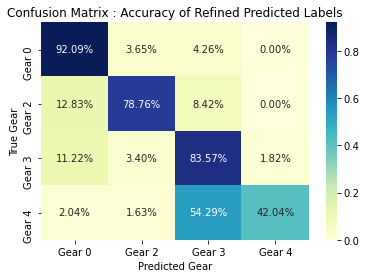

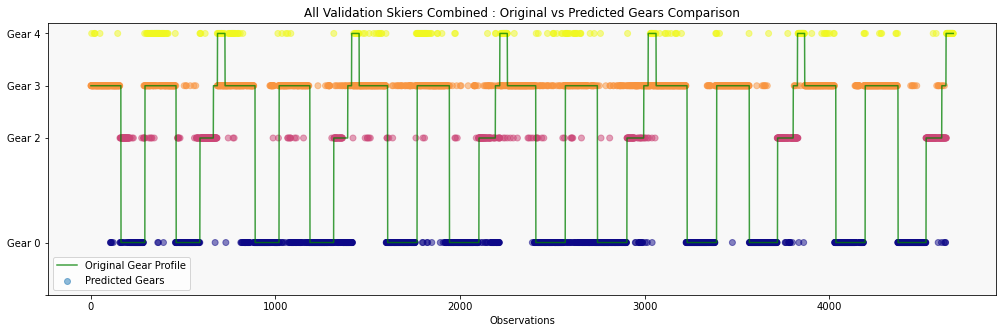

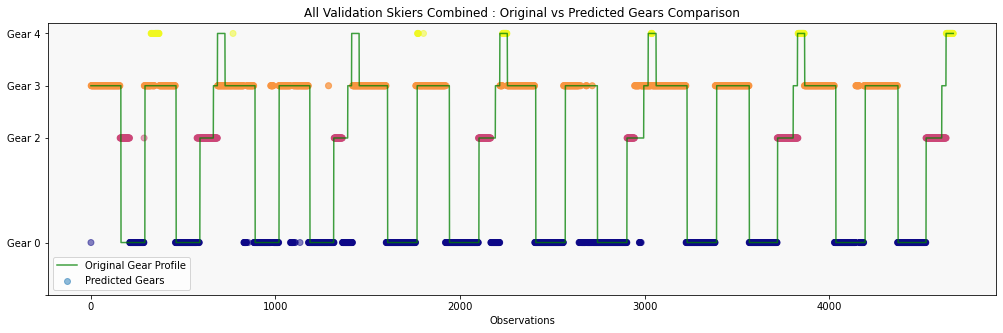

**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
ADDITIONAL EXPERIMENT!...
Selecting Skiers with Lowest Body Mass Index (BMI) for Validation...
Training Skiers : [1, 3, 4, 5, 6, 7]
Validation Skiers : [2, 8, 9, 10]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.754,0.784,0.696,0.784,0.724,0.642,0.659



Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.74      0.80      2328
           2       0.68      0.88      0.77       755
           3       0.79      0.73      0.76      2733
           4       0.45      0.79      0.57       447

    accuracy                           0.75      6263
   macro avg       0.70      0.78      0.72      6263
weighted avg       0.78      0.75      0.76      6263



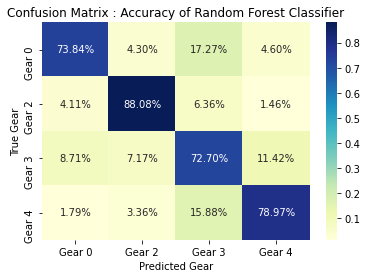

Performance Metrics for Refined Predicted Labels :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC
0,0.811,0.849,0.748,0.849,0.778,0.729



Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.80      0.87      2328
           2       0.74      1.00      0.85       755
           3       0.85      0.77      0.81      2733
           4       0.46      0.83      0.59       447

    accuracy                           0.81      6263
   macro avg       0.75      0.85      0.78      6263
weighted avg       0.84      0.81      0.82      6263



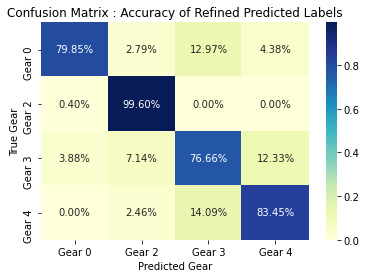

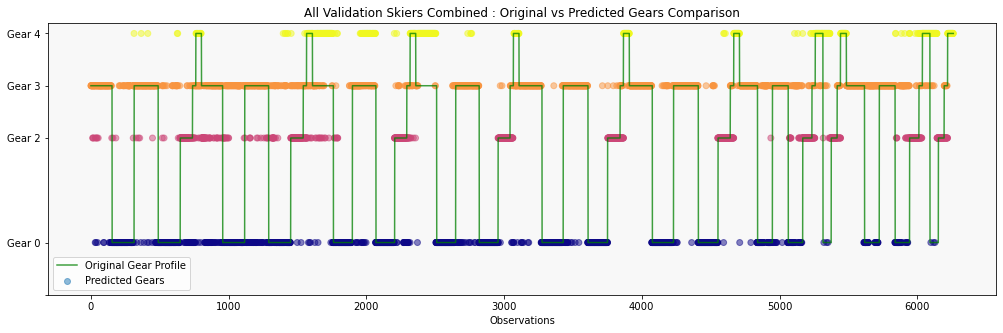

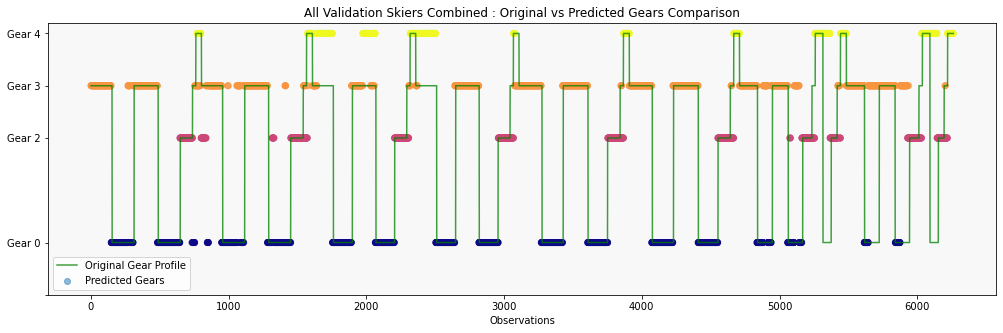

**********************************************************************************************
Randomly Splitting Skiers into Training and Validation Sets...
ADDITIONAL EXPERIMENT!...
Selecting Skiers with Highest Body Mass Index (BMI) for Validation...
Training Skiers : [2, 5, 6, 8, 9, 10]
Validation Skiers : [1, 3, 4, 7]


Evaluating Data with 5-fold CV...

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC,Classifier Score
0,0.65,0.617,0.593,0.617,0.603,0.483,0.619



Classification Report: 
               precision    recall  f1-score   support

           0       0.70      0.60      0.65      2367
           2       0.50      0.58      0.54       825
           3       0.71      0.73      0.72      2717
           4       0.46      0.55      0.50       563

    accuracy                           0.65      6472
   macro avg       0.59      0.62      0.60      6472
weighted avg       0.66      0.65      0.65      6472



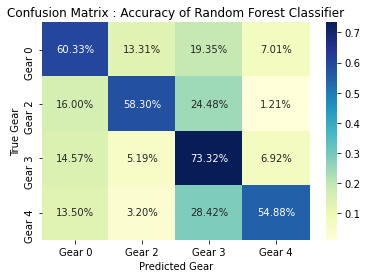

Performance Metrics for Refined Predicted Labels :
----------------------------------------------------------


,Accuracy,Balanced Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),MCC
0,0.7,0.641,0.654,0.641,0.645,0.549



Classification Report: 
               precision    recall  f1-score   support

           0       0.73      0.65      0.69      2367
           2       0.52      0.58      0.55       825
           3       0.74      0.81      0.78      2717
           4       0.62      0.52      0.56       563

    accuracy                           0.70      6472
   macro avg       0.65      0.64      0.65      6472
weighted avg       0.70      0.70      0.70      6472



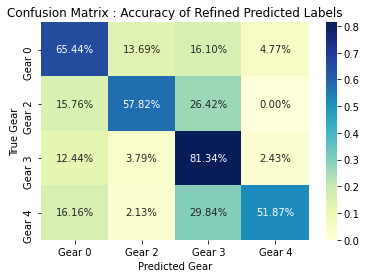

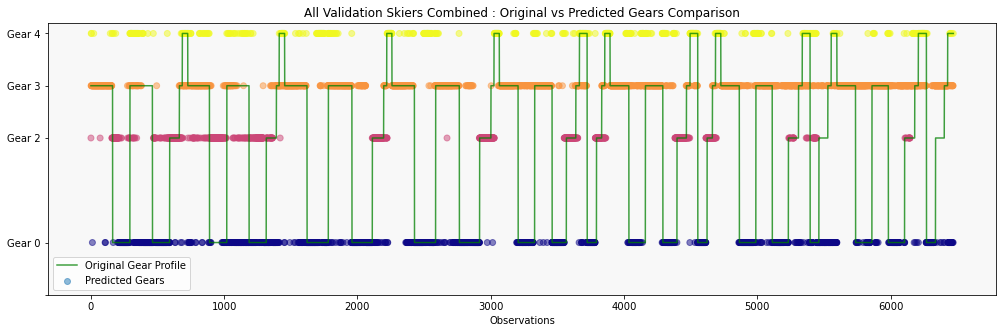

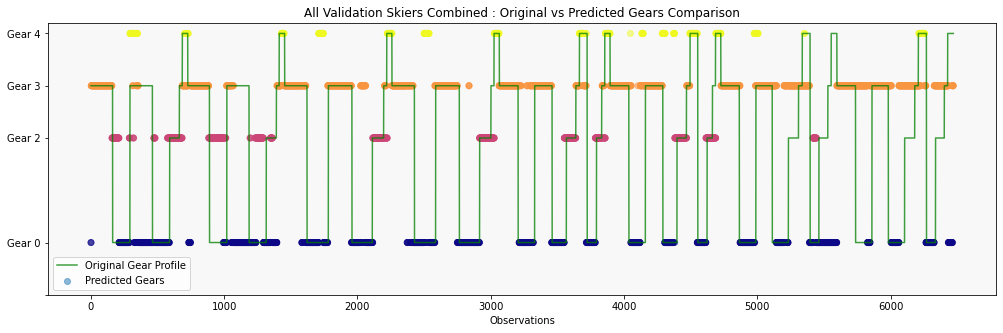

In [15]:
# Create a dataframe that will store data for every run in one table
rfc_results_df = pd.DataFrame(columns=list(['Experiment','Training Skiers','Validation Skiers',
                                           'Accuracy','Balanced Accuracy','MCC',
                                            'Precision (Macro Avg)','Recall (Macro Avg)',
                                            'F1 (Macro Avg)','Classifier Score']))

refined_results_df = pd.DataFrame(columns=list(['Experiment','Training Skiers','Validation Skiers',
                                           'Accuracy','Balanced Accuracy','MCC',
                                            'Precision (Macro Avg)','Recall (Macro Avg)',
                                            'F1 (Macro Avg)','Classifier Score']))


special_cases = ['Selecting All Women Skiers for Validation',
                 'Selecting Tallest Skiers for Validation',
                 'Selecting Skiers with Lowest Body Mass Index (BMI) for Validation',
                 'Selecting Skiers with Highest Body Mass Index (BMI) for Validation']

for i in range(0,len(special_cases)):
    
    #Load training and validation data based on randomly selected skiers
    X_train, X_valid, y_train, y_valid, y_plot_data, train_skiers_list, val_skiers_list = split_train_test_data(df_info, skier_list, validation_skiers, special_case=i)
    
    display(HTML(f'<p><strong><span style="font-size: 24px; color: rgb(0, 168, 133);">Additional Experiment {i+1} :<br> {special_cases[i]} <br>Training Skiers : {train_skiers_list}  ||  Validation Skiers : {val_skiers_list}</span></strong></p>'))

    display(HTML(f'<p><em><strong><span style="font-size: 20px; background-color: rgb(251, 160, 38);">Original Results&nbsp;</span></strong></em></p>'))
    # Evaluate the model using validation data and output performance metrics
    results, all_y_pred, CM_arr, class_report = evaluate(rfc,X_train, y_train,X_valid, y_valid, 'Random Forest Classifier')
    
    display(HTML(f'<p><em><strong><span style="font-size: 20px; background-color: rgb(251, 160, 38);">Refined Results&nbsp;</span></strong></em></p>'))
    refined_results, refined_all_y_pred, refined_CM_arr, refined_class_report = refine_predicted_labels(y_valid, all_y_pred, 'Refined Predicted Labels')
    
    display(HTML(f'<p><strong><span style="font-size: 20px; color: rgb(239, 239, 239); background-color: rgb(71, 85, 119);"><u>ORIGINAL RESULTS</u> : Predicted Gears vs. Original Gears Comparison</span></strong></p>'))
    # Plot the predicted and True gears of validation data to visualize quality of predictions made
    plot_predicted_gear_comparison(y_plot_data,all_y_pred,False)
    
    display(HTML(f'<p><strong><span style="font-size: 20px; color: rgb(239, 239, 239); background-color: rgb(71, 85, 119);"><u>REFINED RESULTS</u> : Predicted Gears vs. Original Gears Comparison</span></strong></p>'))
    plot_predicted_gear_comparison(y_plot_data,refined_all_y_pred,False)
    
    # Store all results
    temp_all_metrics =  ["" for x in range(10)]
    temp_all_metrics[0] = special_cases[i]
    temp_all_metrics[1] = train_skiers_list
    temp_all_metrics[2] = val_skiers_list
    temp_all_metrics[3] = results[0]
    temp_all_metrics[4] = results[1]
    temp_all_metrics[5] = results[5]
    temp_all_metrics[6] = results[2]
    temp_all_metrics[7] = results[3]
    temp_all_metrics[8] = results[4]
    temp_all_metrics[9] = class_report

    rfc_results_df.loc[len(rfc_results_df)] = temp_all_metrics

    # Store all refined results
    temp_all_metrics =  ["" for x in range(10)]
    temp_all_metrics[0] = special_cases[i]
    temp_all_metrics[1] = train_skiers_list
    temp_all_metrics[2] = val_skiers_list
    temp_all_metrics[3] = refined_results[0]
    temp_all_metrics[4] = refined_results[1]
    temp_all_metrics[5] = refined_results[5]
    temp_all_metrics[6] = refined_results[2]
    temp_all_metrics[7] = refined_results[3]
    temp_all_metrics[8] = refined_results[4]
    temp_all_metrics[9] = class_report

    refined_results_df.loc[len(refined_results_df)] = temp_all_metrics
    
    print('\n\n')
    display(HTML(f'<p><hr></p>'))
    


## Summary of Refined Results for Additional Expermients
[Back To Top](#home)


In [16]:
rfc_results_df

,Experiment,Training Skiers,Validation Skiers,Accuracy,Balanced Accuracy,MCC,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),Classifier Score
0,Selecting All Women Skiers for Validation,"[1, 2, 3, 5, 6, 8, 9]","[10, 7, 4]",0.725,0.728,0.613,0.695,0.728,0.708,precision recall f1-score ...
1,Selecting Tallest Skiers for Validation,"[4, 5, 6, 7, 8, 9, 10]","[1, 2, 3]",0.763,0.694,0.631,0.659,0.694,0.674,precision recall f1-score ...
2,Selecting Skiers with Lowest Body Mass Index (...,"[1, 3, 4, 5, 6, 7]","[2, 8, 9, 10]",0.754,0.784,0.642,0.696,0.784,0.724,precision recall f1-score ...
3,Selecting Skiers with Highest Body Mass Index ...,"[2, 5, 6, 8, 9, 10]","[1, 3, 4, 7]",0.650,0.617,0.483,0.593,0.617,0.603,precision recall f1-score ...


In [17]:
refined_results_df

,Experiment,Training Skiers,Validation Skiers,Accuracy,Balanced Accuracy,MCC,Precision (Macro Avg),Recall (Macro Avg),F1 (Macro Avg),Classifier Score
0,Selecting All Women Skiers for Validation,"[1, 2, 3, 5, 6, 8, 9]","[10, 7, 4]",0.804,0.807,0.723,0.785,0.807,0.791,precision recall f1-score ...
1,Selecting Tallest Skiers for Validation,"[4, 5, 6, 7, 8, 9, 10]","[1, 2, 3]",0.841,0.741,0.748,0.795,0.741,0.757,precision recall f1-score ...
2,Selecting Skiers with Lowest Body Mass Index (...,"[1, 3, 4, 5, 6, 7]","[2, 8, 9, 10]",0.811,0.849,0.729,0.748,0.849,0.778,precision recall f1-score ...
3,Selecting Skiers with Highest Body Mass Index ...,"[2, 5, 6, 8, 9, 10]","[1, 3, 4, 7]",0.700,0.641,0.549,0.654,0.641,0.645,precision recall f1-score ...


<a id="refined_obs"></a>

## Observations of Refining Predicted Labels
[Back To Top](#home)


Similar to the above, we see an improvement in quality of predicted labels once they are refined using a majority filter. Using this method, we end up achieving improved results in each of the experiments. However, Gear 4 is still usually poorly predicted and the additional experiment with validation skiers having high BMI is still the lowest performing experiment as this refining method works on the already predicted labels by claning them a bit to have more consistency during each set of gears observations.

---
---
---
---
---